In [1]:
import numpy as np
import torch,torchvision
import matplotlib.pyplot as plt
from medmnist import DermaMNIST
%matplotlib notebook

**Note: I will set the device here**

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = 'cuda:0'
else:
    print("No GPU Found")
device

device(type='mps')

# Homework 3

Homework 3 will cover materials from chapter 5 (CNNs), 6 (CNNs for classification), and 7 (CNN for segmentation).

Ideally, computational, analytical, and written parts can be submitted as part of this jupyter notebook.

Homework should be submitted by email, to dtward@mednet.ucla.edu.

Coding parts can be submitted as part of the notebook, using as many cells as is convenient.

Analytical parts should be submitted with math rendered using Latex in markdown cells, using as many cells as is convenient.

Written parts can use markdown cells.

If you do not know how to type equations in Latex, and cannot work out enough of the basics using the equations provided here, please email me and we'll work something out.

There is lots of exposition in this homework assignment.  All the problems that need to be solved are labeled with the the title "Problem".

Homework will be due on Monday March 11 (two weeks from today).

In homework 3, 90% of your grade will be based on the quality and accuracy of the work you do in this notebook.  10% of your grade will be based on how well your CNNs perform relative to the other students in the class.

## Part 1, data augmentation

### 1.1 Our dataset

We will use the dermaMNIST dataset for this problem and the following one.


In [3]:
from medmnist import DermaMNIST
dataset_train = DermaMNIST(split='train',download=True,transform=torchvision.transforms.ToTensor())
dataset_val = DermaMNIST(split='val',download=True,transform=torchvision.transforms.ToTensor())
dataset_test = DermaMNIST(split='test',download=True,transform=torchvision.transforms.ToTensor())

Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz


<IPython.core.display.Javascript object>


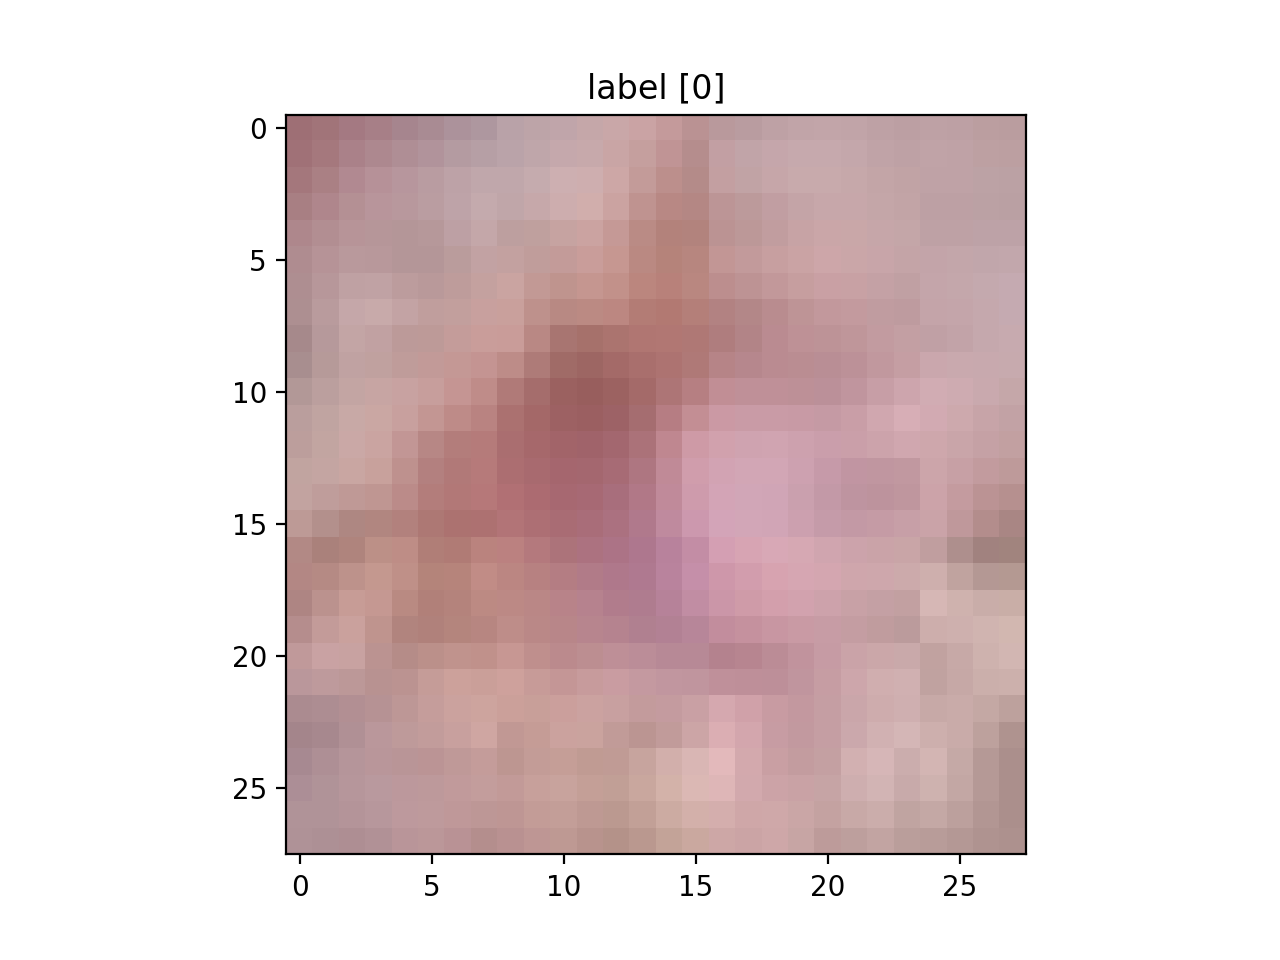

<IPython.core.display.Javascript object>


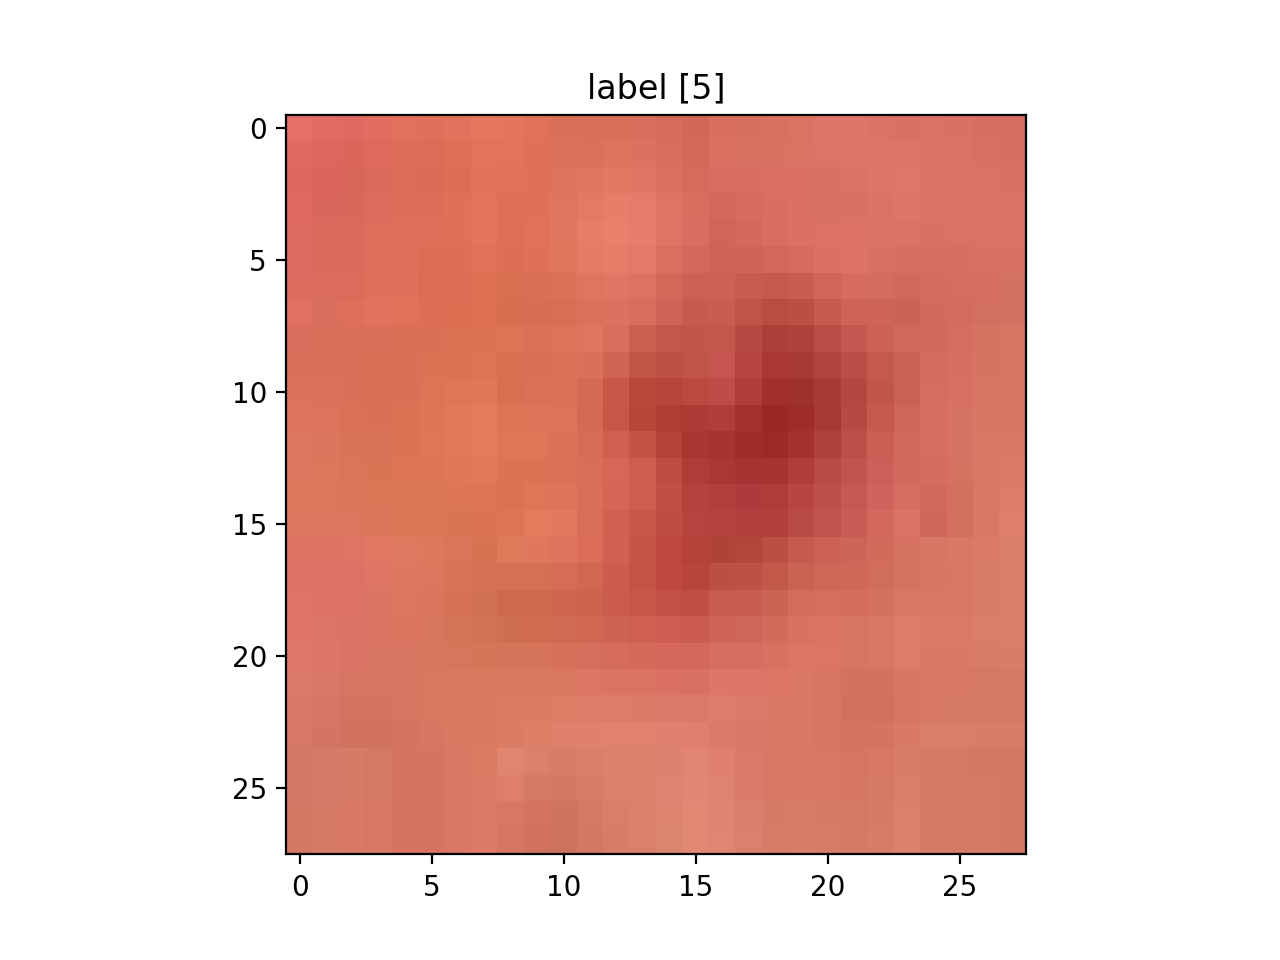

Text(0.5, 1.0, 'label [5]')

In [4]:
I,l = dataset_train[0]
fig,ax = plt.subplots()
ax.imshow(I.permute(1,2,0))
ax.set_title(f'label {l}')

I,l = dataset_train[1]
fig,ax = plt.subplots()
ax.imshow(I.permute(1,2,0))
ax.set_title(f'label {l}')

### 1.2 a dataset randomizer

Below we provide some code to apply random transformations to our images or labels, and visualize some examples.

We show 5 different label-preserving transformations of the same image.

Note that there are two empty sections that need to be filled in, which are the next two problems.

In [5]:
def interpn(x,I,Xs,**kwargs):
    ''' A utility function based around torch's grid sample function
    but with interface the same as numpy's interpn'''
    # scale sample points to -1 to 1
    x0 = torch.stack([x[0][0],x[1][0]])
    x1 = torch.stack([x[0][-1],x[1][-1]])
    Xs = Xs - x0
    Xs = Xs / (x1 - x0)
    Xs = Xs*2-1
    
    # add and remove a batch dimension if necessary
    if I.ndim == 3:        
        Is = torch.nn.functional.grid_sample(I[None],Xs[None].flip(-1),align_corners=True,**kwargs)[0]
    else:
        Is = torch.nn.functional.grid_sample(I,Xs.flip(-1),align_corners=True,**kwargs)
    return Is

In [6]:
class RandomizedDataset(torch.utils.data.Dataset):
    ''' A class to apply randomizations to your dataset'''
    def __init__(self,dataset,
                 random_rotate=False,
                 random_reflect=False, 
                 random_affine=False,
                 random_deformation=False,
                 random_window_level=False,
                 random_gamma=False,
                 random_noise=False,
                ):
        # set the dataset to a member variable
        self.dataset = dataset
        
        
        
        # set the options to apply randomizations to member variables
        self.random_rotate = random_rotate
        self.random_reflect = random_reflect
        self.random_affine = random_affine
        self.random_deformation = random_deformation
        self.random_window_level = random_window_level
        self.random_gamma = random_gamma
        self.random_noise = random_noise
        
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,i):
        I,l = self.dataset[i]
        # check if the labels are segmentation labels
        # if they are, we will have to apply the same transformations
        # to the labels and the images
        if l.ndim == 1:
            l_is_image = False
        else:
            l_is_image = True
        
        # apply geometric transformations
        # note that we will need to apply the same transform to the image and segmentation
        if self.random_rotate:
            nrot = np.random.randint(4)
            I = torch.rot90(I,nrot,dims=(-1,-2))
            if l_is_image:
                l = torch.rot90(l,nrot,dims=(-1,-2))
        
        if self.random_reflect:
            if np.random.rand()>0.5:
                I = torch.flip(I,dims=(-1,-2))
                if l_is_image:
                    l = torch.flip(l,dims=(-1,-2))
        # get zero centered pixel locations
        x0 = torch.arange(I.shape[-2]) - (I.shape[-2]-1)/2
        x1 = torch.arange(I.shape[-1]) - (I.shape[-1]-1)/2
        X = torch.stack(torch.meshgrid(x0,x1,indexing='ij'),-1)        
        if self.random_affine:
            
            # a random matrix is added to identity for the linear part
            L = torch.eye(2) + torch.randn(2,2)*0.1
            # a random translation with standard deviation of 3 pixels is added to the tanslation
            T = torch.randn(2,1)*3
            # concatenate them
            A = torch.concatenate((L,T),-1)
            A = torch.concatenate((A,torch.tensor([[0.0,0.0,1.0]])),-2)
            Ai = torch.linalg.inv(A)
            # get sample points
            Xs = (Ai[:2,:2]@X[...,None])[...,0] + Ai[:2,-1]
            I = interpn([x0,x1],I,Xs,padding_mode='border')
            if l_is_image:                
                # note we use 'nearest neighbor' interpolation for labels
                l = interpn([x0,x1],l,Xs,mode='nearest',padding_mode='border')
        if self.random_deformation:
            # YOUR WORK HERE
            # 
            # 1. 
            # create 2 28x28 torch tensors which will represent the row and col components of your displacement fields
            # 
            # p0 = ...
            # p1 = ...  
            p0 = torch.randn(28, 28)
            p1 = torch.randn(28, 28)
            # 2. 
            # multiply them by whatever standard deviation you choose, this will relate to the magnitude of displacement
            # 
            std_deviation = 2.0
            p0 *= std_deviation
            p1 *= std_deviation
            # 3. 
            # blur it with a gaussian kernel of whatever width you choose
            # I suggest using the function:  torchvision.transforms.functional.gaussian_blur            
            # but there are other choices we have covered in class        
            # if you use this choice you will have to add a leading dimension to the input, and remove it from the output
            # example of adding and removing a leading dimension:
            # * blurred_image = blur( my_image[None])[0]
            # 
            kernel_size = 3
            sigma = 1.0 

            # Apply Gaussian blur to p0 and p1
            p0 = torchvision.transforms.functional.gaussian_blur(p0[None], kernel_size, sigma)[0]
            p1 = torchvision.transforms.functional.gaussian_blur(p1[None], kernel_size, sigma)[0]
            # 4. 
            # stack p0 and p1 into a 28x28x2 array and            
            # interpolate your images at X - your_random_displacement_field
            # Xs = X - torch.stack((p0,p1))
            # ...
            # see the above affine transform for any help with interpolation
            # 
            # make sure the std and kernel size you choose lead to realistic images
            displacement_field = torch.stack((p0, p1), dim=-1)
            Xs = X - displacement_field
            I = interpn([x0, x1], I, Xs, padding_mode='border')
            if l_is_image:
                l = interpn([x0, x1], l, Xs, mode='nearest', padding_mode='border')
            pass
                
            
            
            
        
        # apply pixel intsenity transforations
        # these will be applied only to the image
        # and not to the labels
        if self.random_window_level:
            # YOUR WORK HERE!
            # choose a vmin randomly between 0 and 0.25
            # choose a vmax randomly between 0.75 and 1
            # rescale the image so that vmin maps to 0, and vmax maps to 1
            # clip any pixels less than 0 to the value 0
            # clip any pixels greater than 1 to the value 1
            vmin = torch.FloatTensor(1).uniform_(0, 0.25).item()
            vmax = torch.FloatTensor(1).uniform_(0.75, 1).item()
            I = (I - vmin) / (vmax - vmin)
            I = torch.clamp(I, min=0)
            I = torch.clamp(I, max=1)
            pass
            
        if self.random_gamma:            
            gamma_ = (np.random.rand()*2-1) # between -1 and 1
            gamma = 2.0**gamma_ # between 0.5 and 2.0
            I = I**gamma
            
        if self.random_noise:
            frac = 0.05
            I = I*(1-frac) + torch.rand(*I.shape)*frac
        return I,l
        
        
    

<IPython.core.display.Javascript object>


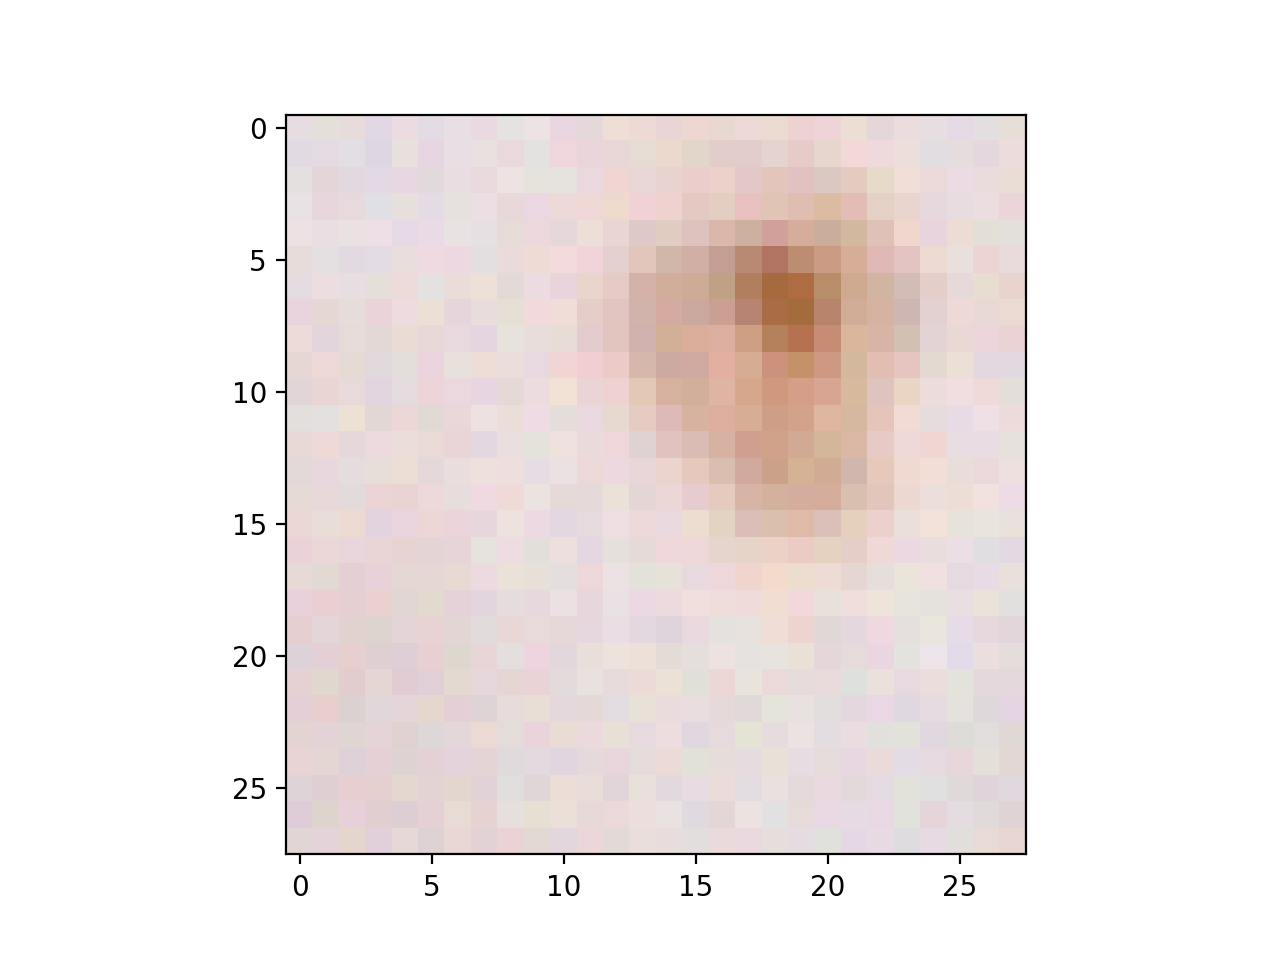

<IPython.core.display.Javascript object>


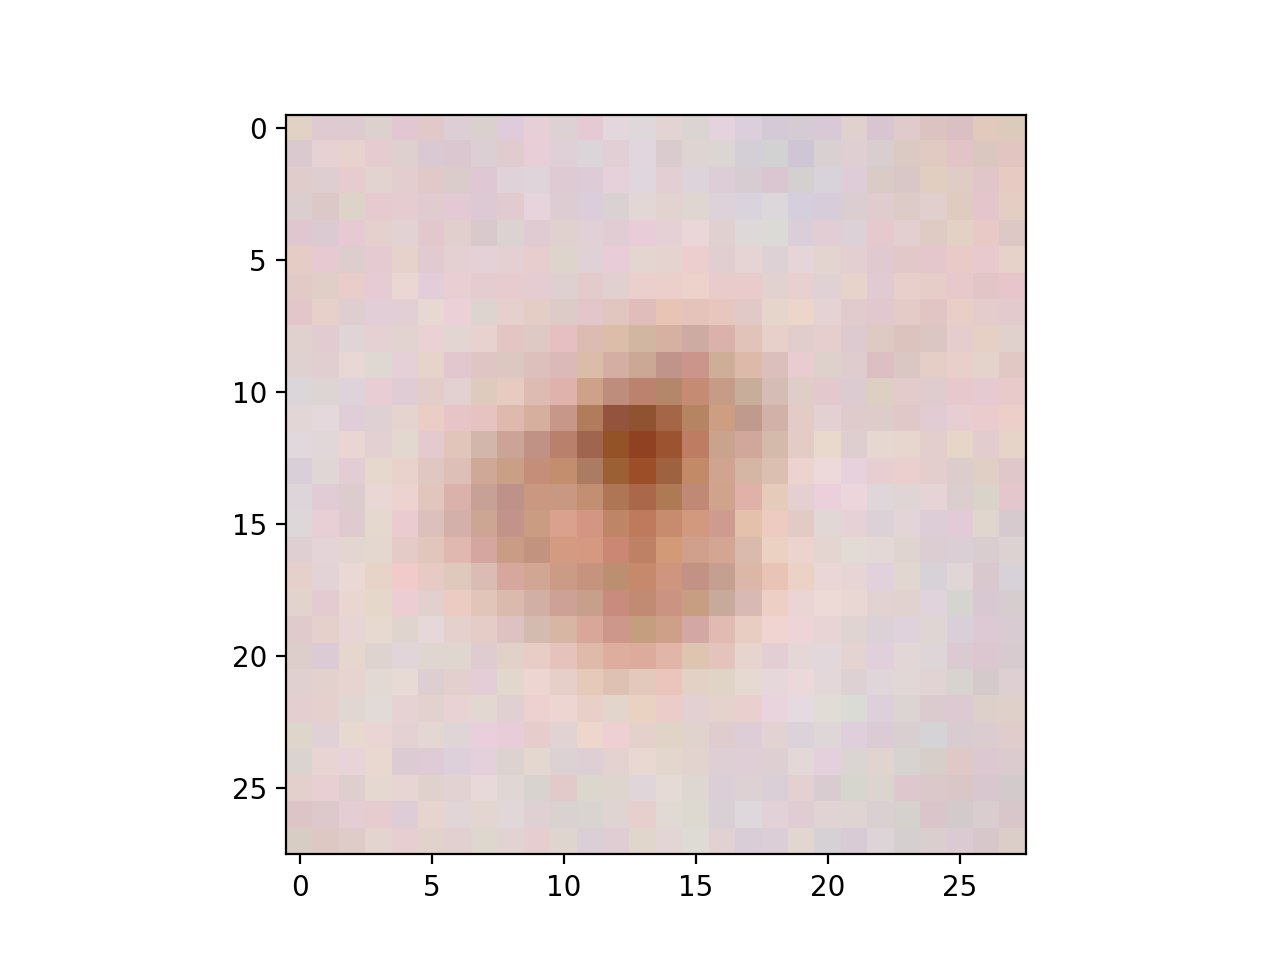

<IPython.core.display.Javascript object>


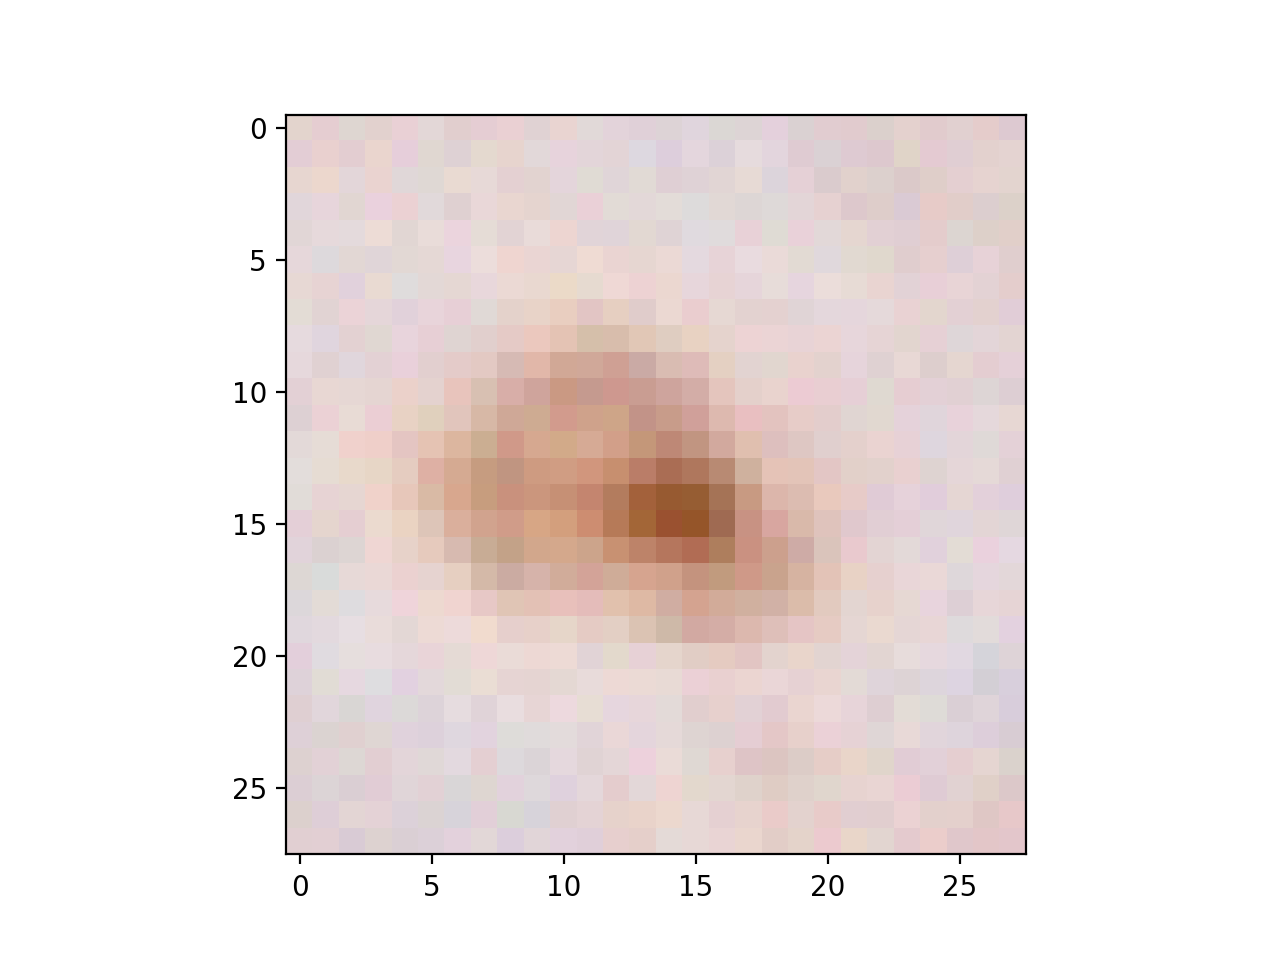

<IPython.core.display.Javascript object>


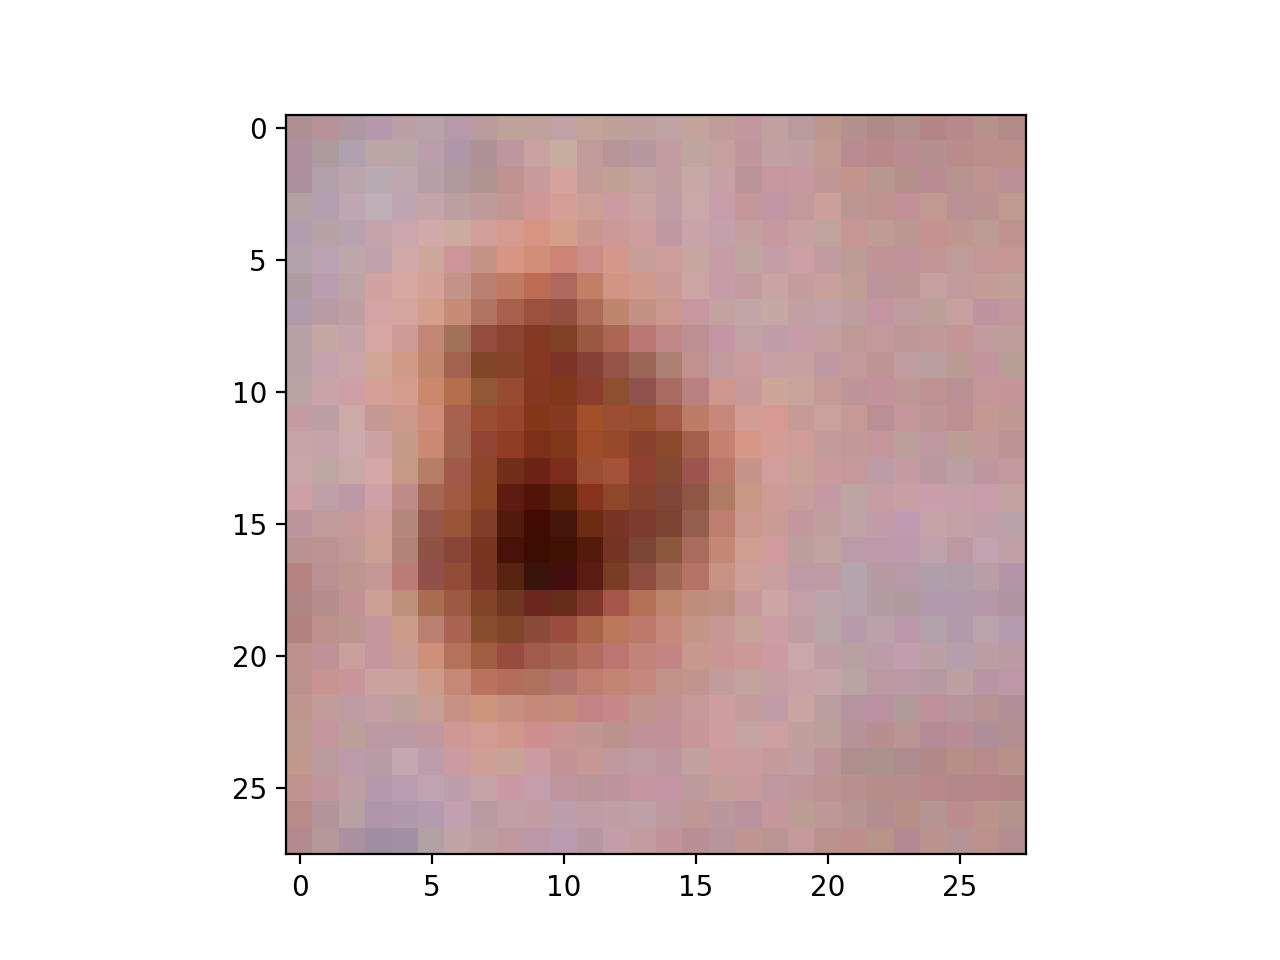

<IPython.core.display.Javascript object>


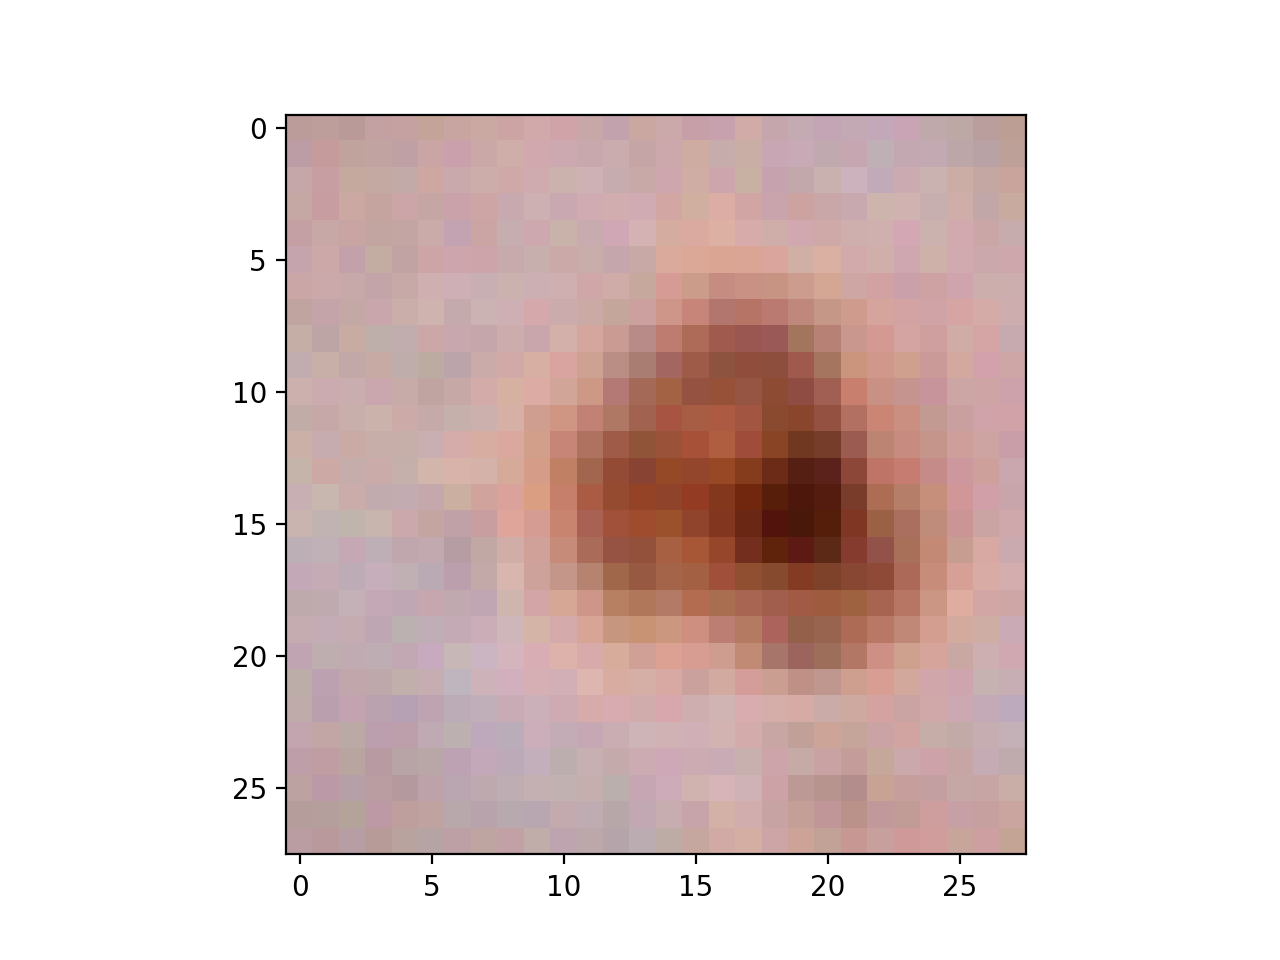

In [7]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_rotate=True,
    random_reflect=True,    
    random_affine=True,        
    random_noise=True,
    random_gamma=True,    
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

### Problem 1.3 

Complete the code in the random_window_level section.  Show 5 different random transformations of the same image using the code below.


<IPython.core.display.Javascript object>


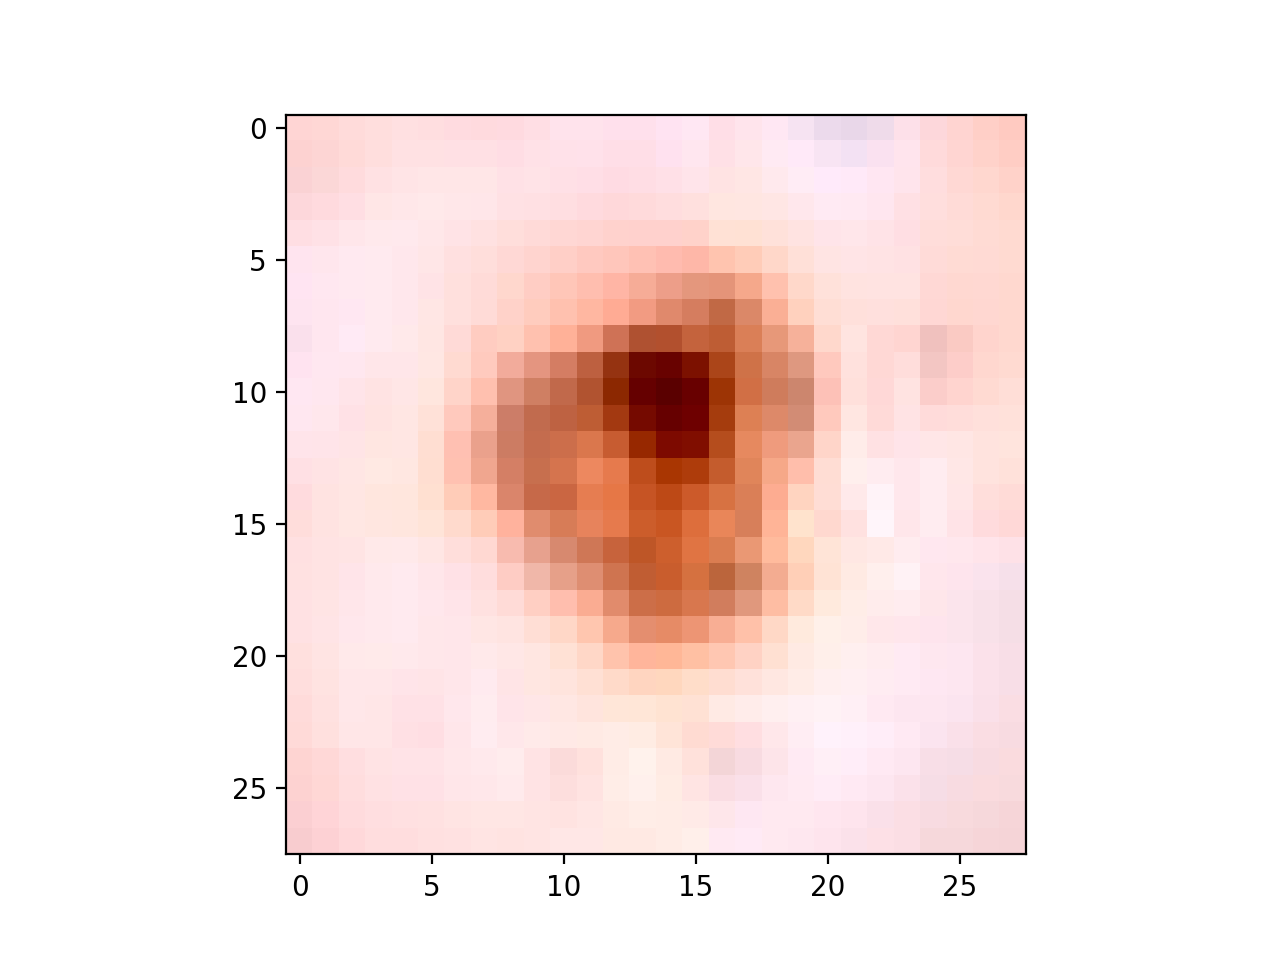

<IPython.core.display.Javascript object>


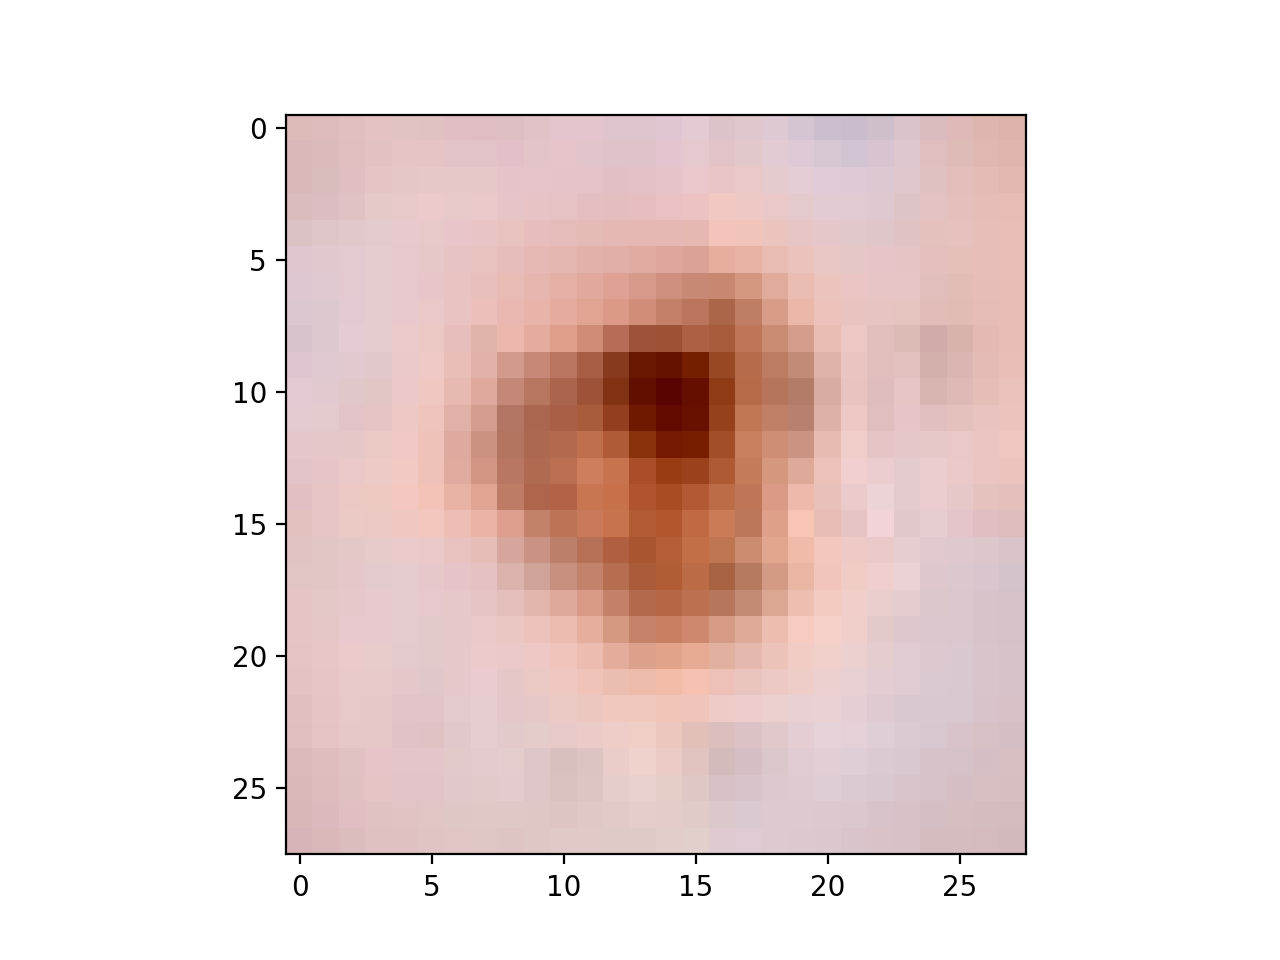

<IPython.core.display.Javascript object>


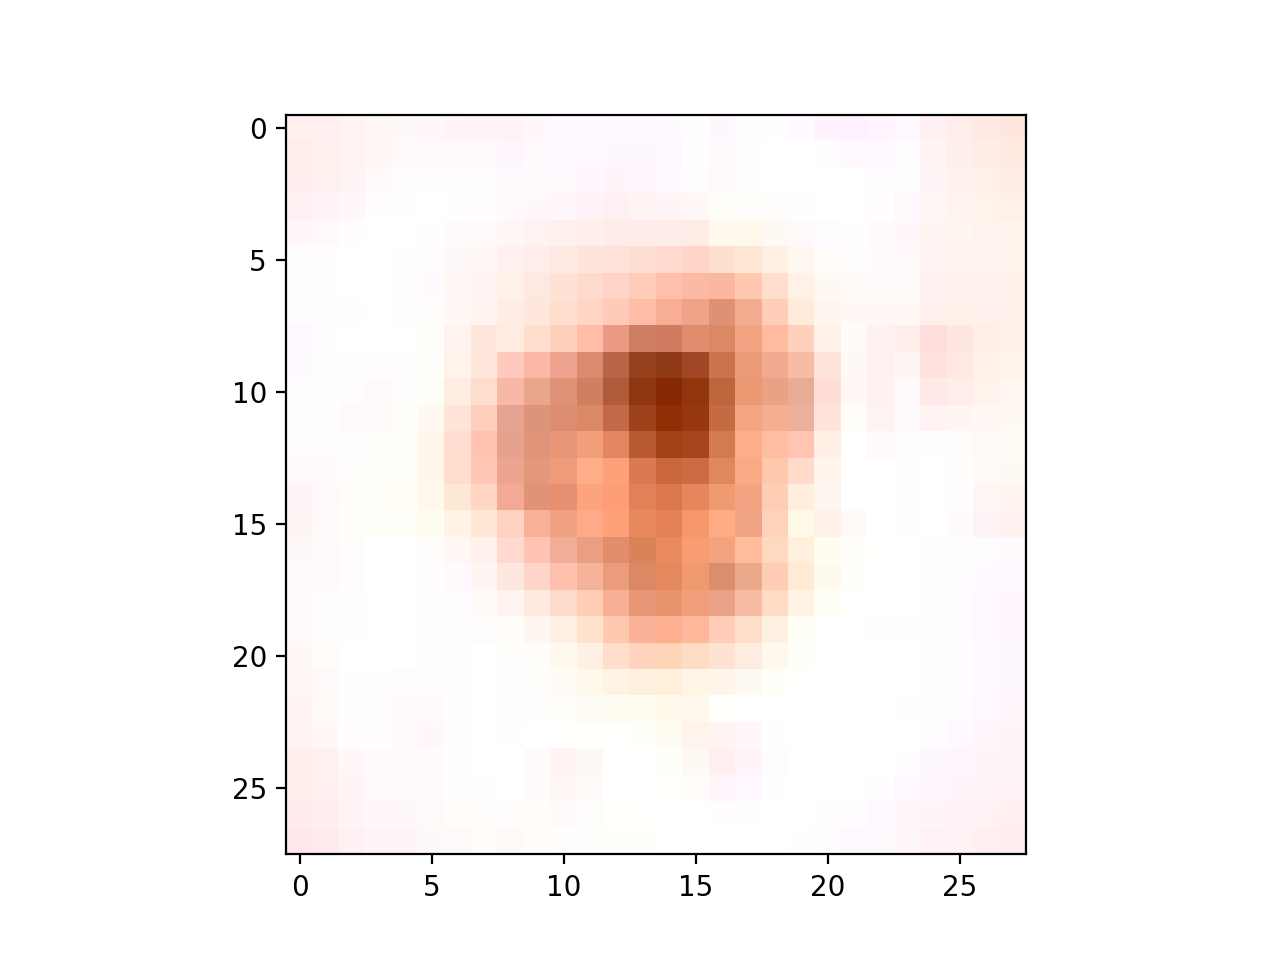

<IPython.core.display.Javascript object>


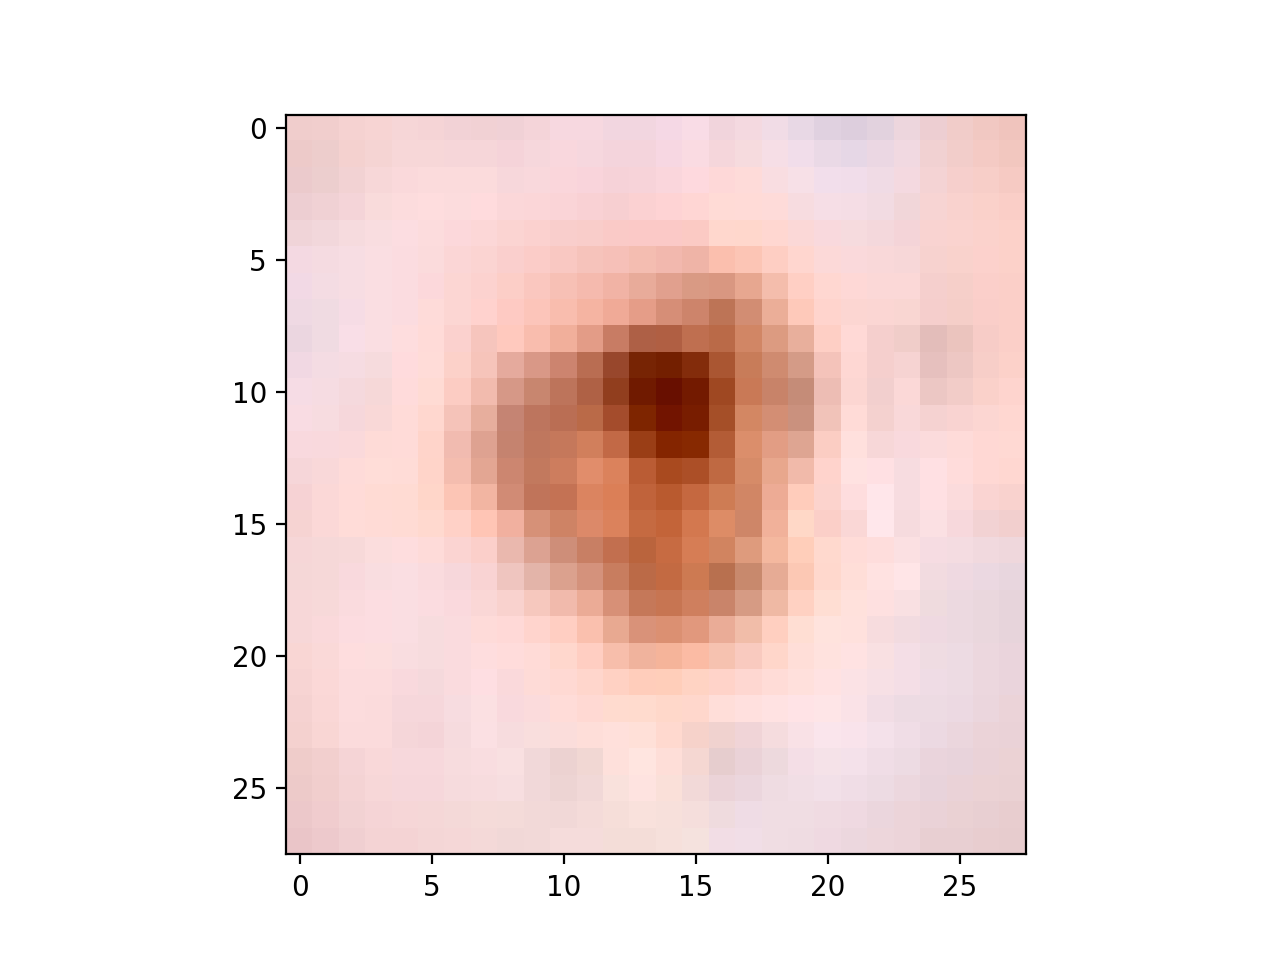

<IPython.core.display.Javascript object>


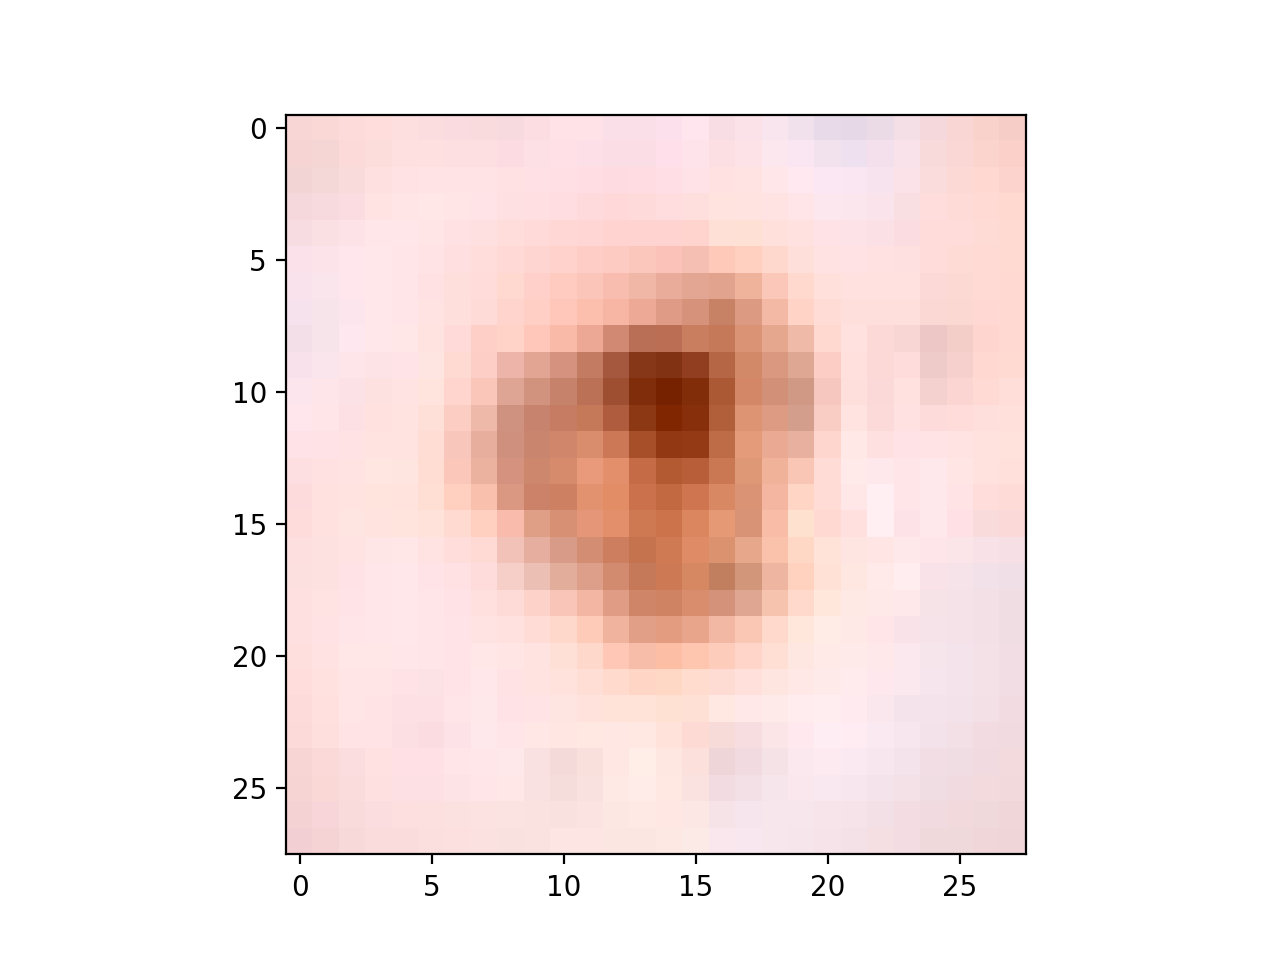

In [8]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_window_level=True, 
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

### Problem 1.4

Complete the code in the random deformation section. Show 5 different random transformations of the same image using the code below.

<IPython.core.display.Javascript object>


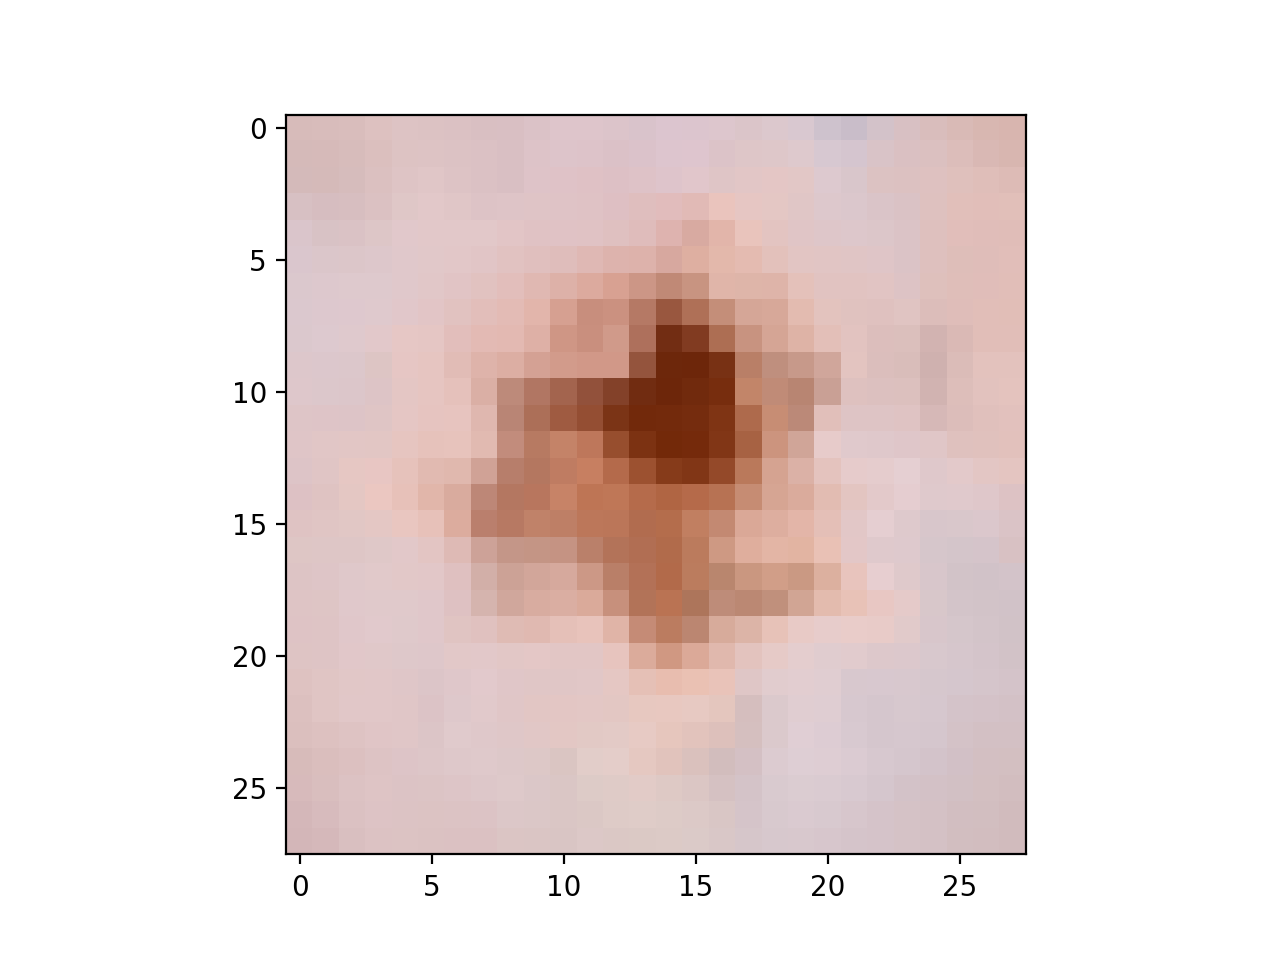

<IPython.core.display.Javascript object>


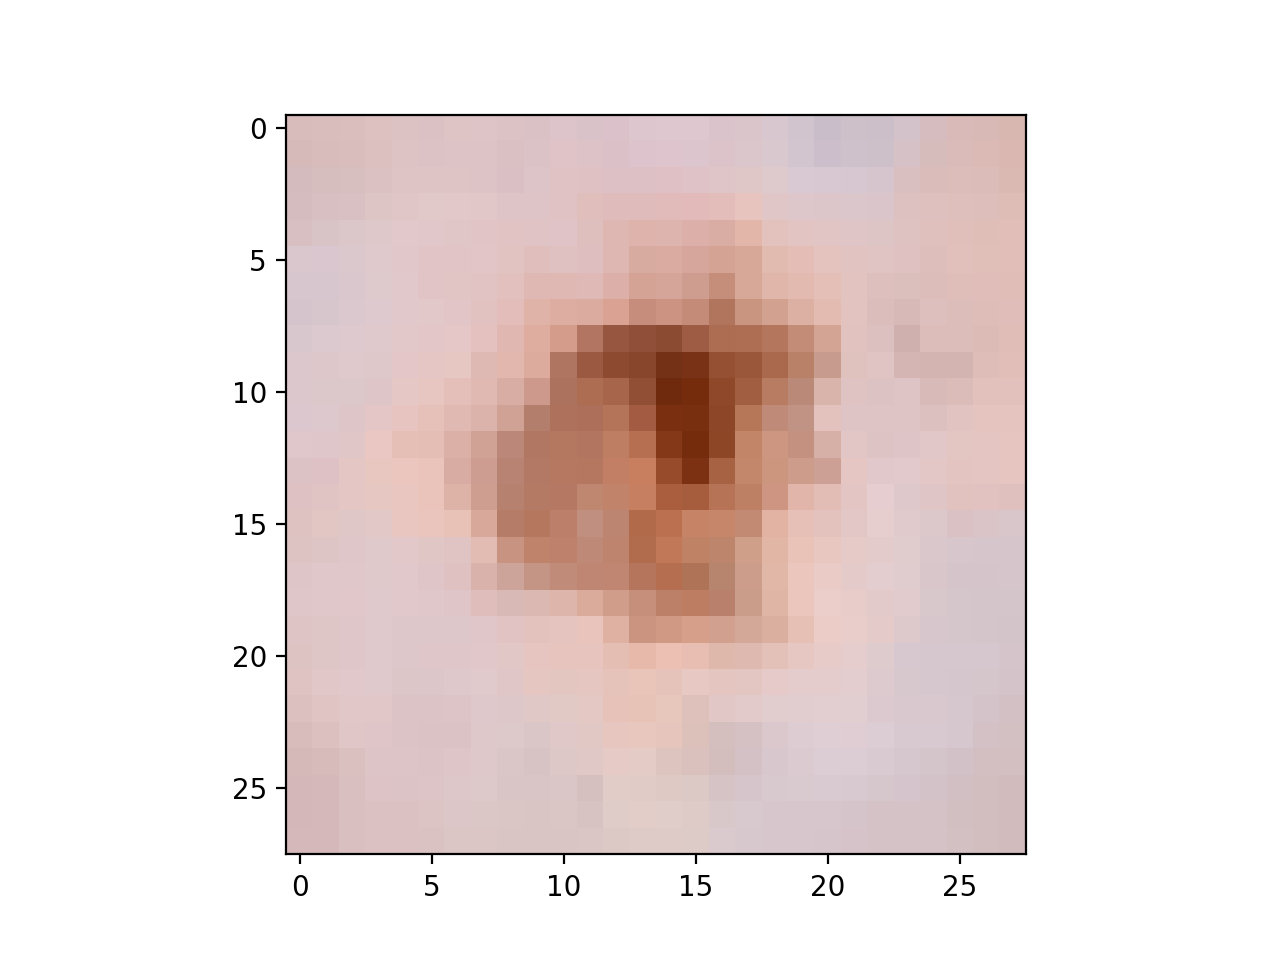

<IPython.core.display.Javascript object>


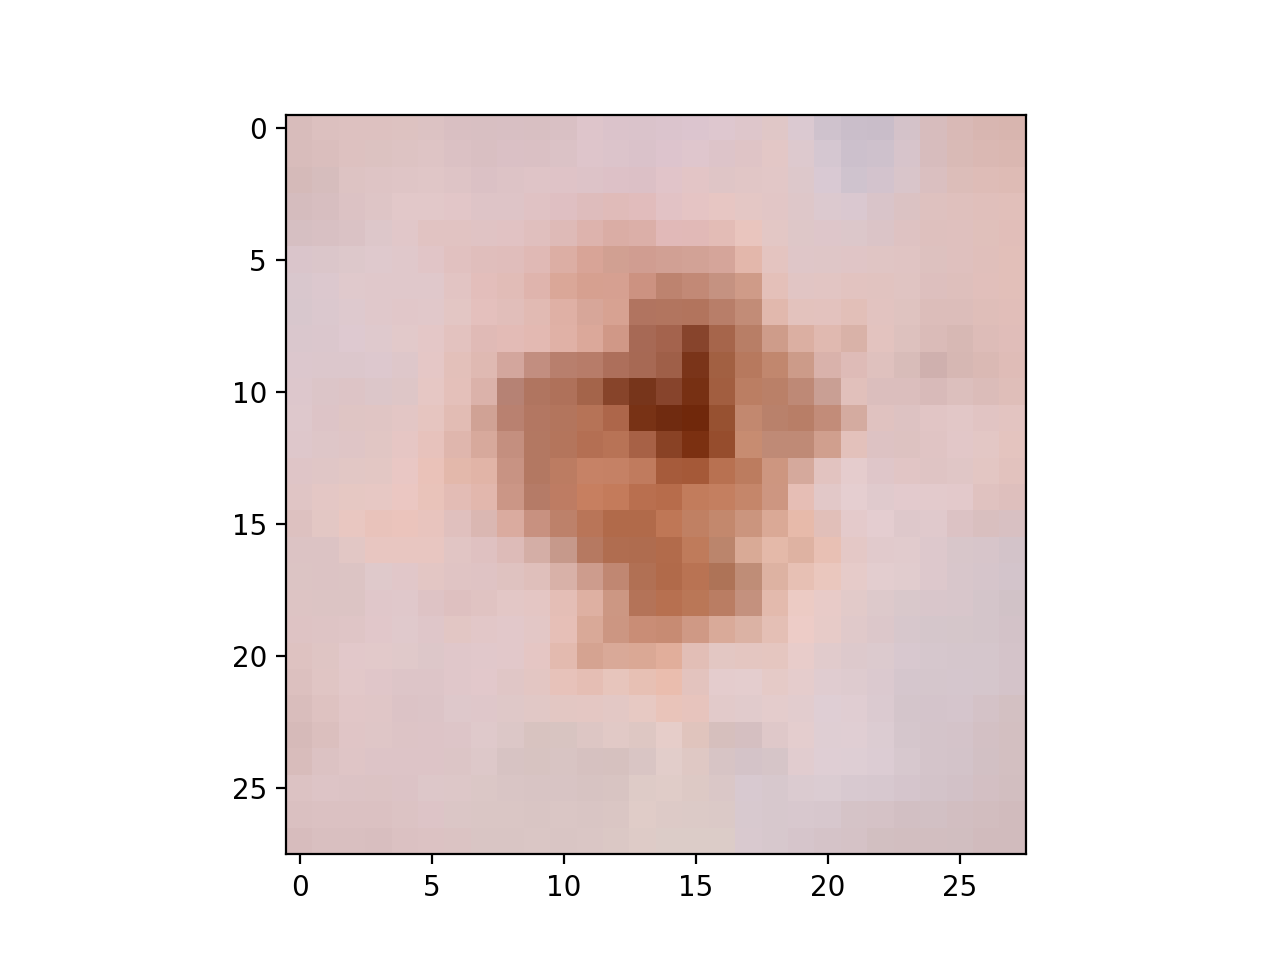

<IPython.core.display.Javascript object>


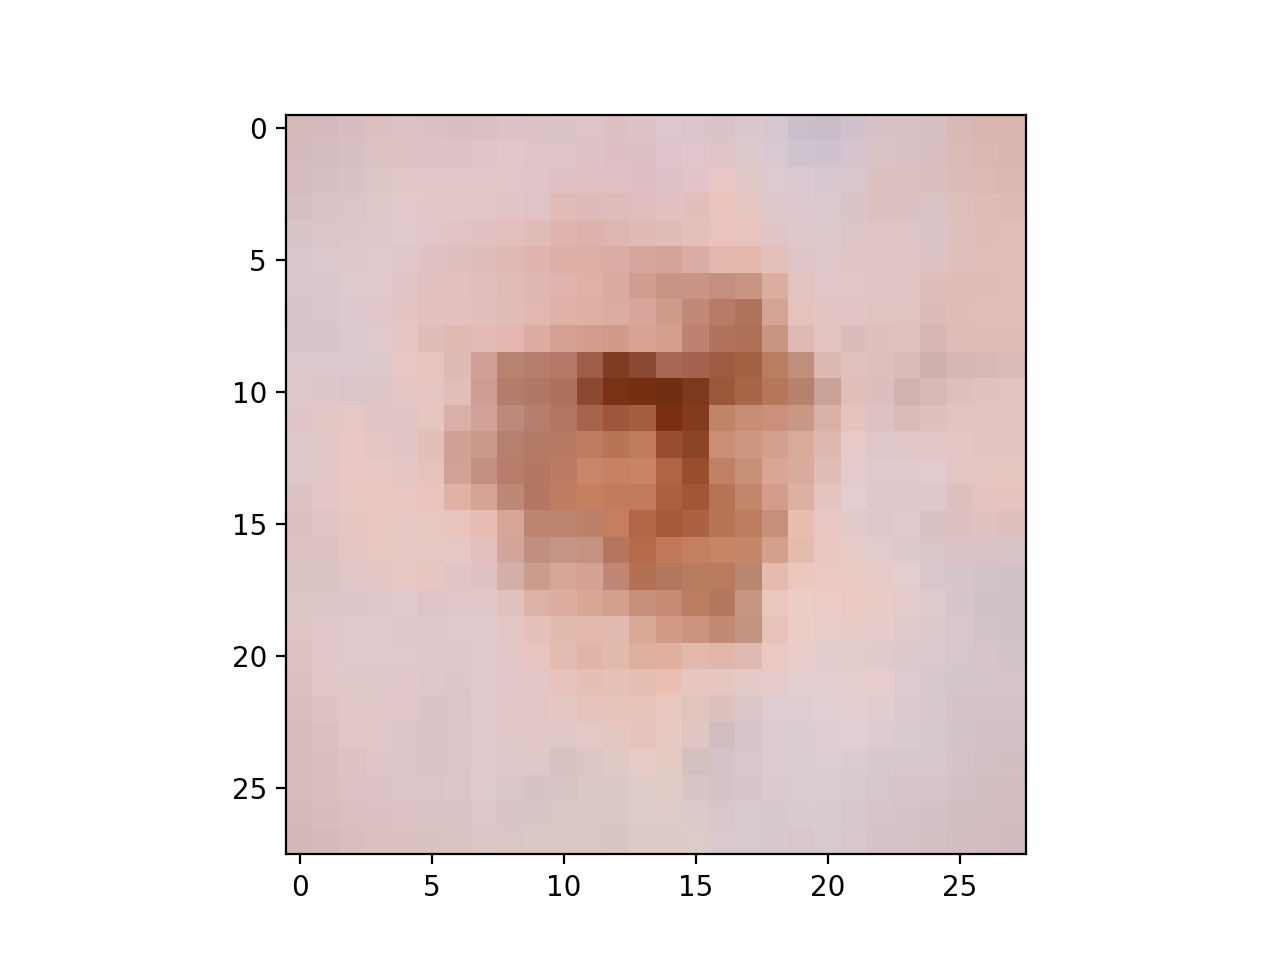

<IPython.core.display.Javascript object>


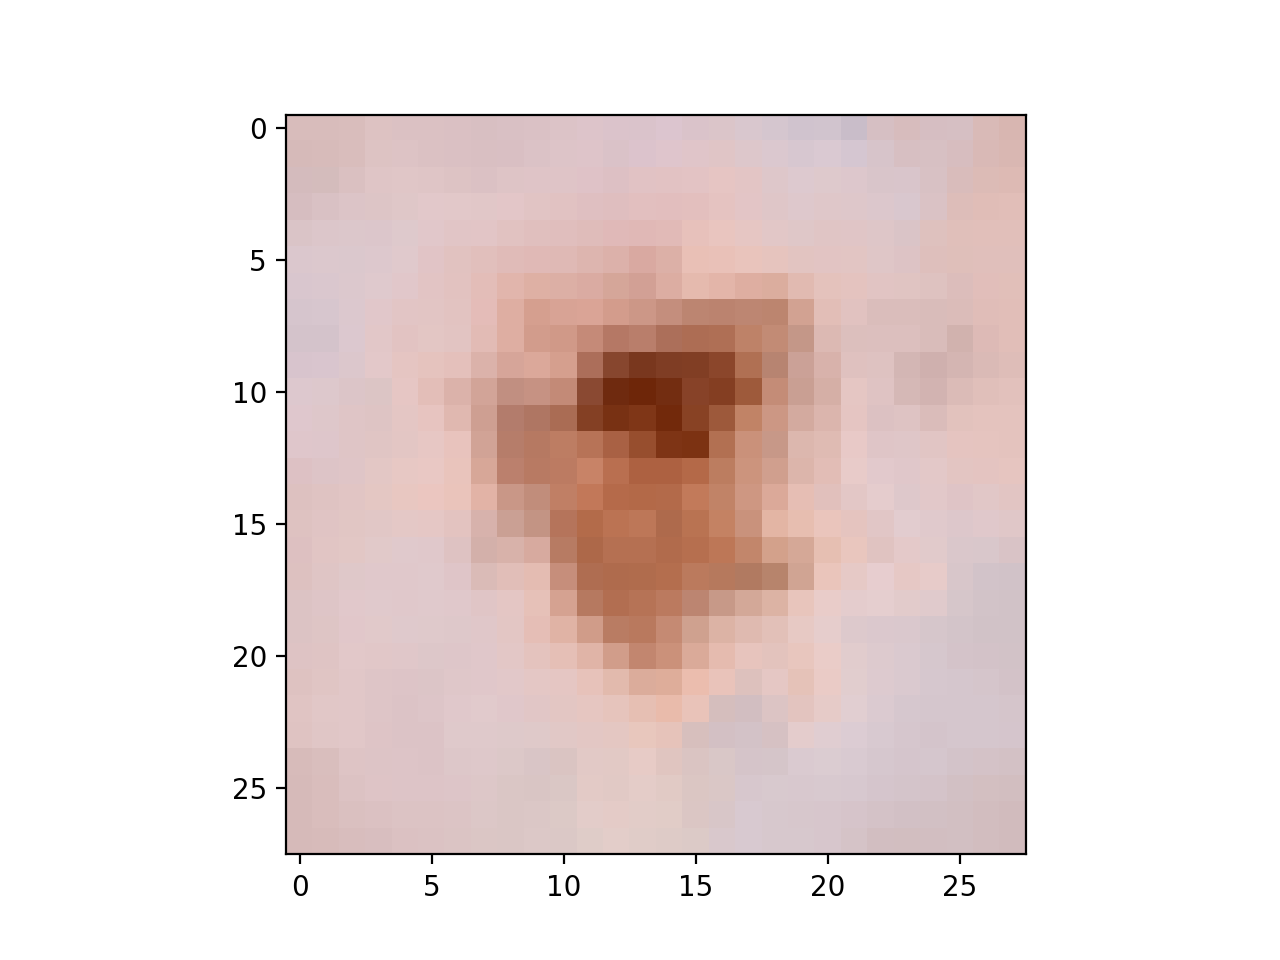

In [9]:
dataset_train_randomized = RandomizedDataset(
    dataset_train,
    random_deformation=True, 
)
for i in range(5):
    I,l = dataset_train_randomized[4]
    fig,ax = plt.subplots()
    ax.imshow(I.permute(1,2,0))

## Part 2, image classification

### Problem 2.1

Design at least two CNNs for classifying the DermaMNIST dataset.

You can choose any design you want, but at least one of the models should not be a copy of what we showed in class.

You may choose to vary the depth or width of the network, the type of data augmentation, any regularization, the loss function, the optimizer, etc.

Train them on the training set (for however long you want), and test their accuracy on the validation set.

Choose the best performing model on the validation set, and report its accuracy on the test set.

I will rerun your notebook, and evaluate perforance in terms of accuracy on a random subset of the test set.  The random subset will be the same for all students.  5% of your grade (out of 100%) on this assignment will be based on your accuracy relative to the other students.  The student with the highest accuracy will recieve 5%. The student with the lowest accuracy will recieve 0%.  The others will vary linearly between these extremes.

## 1.0 Load in our Data

1. I will use the base load in for the data and use our dataset class from above if required later on

### 1.1 Loading in training data
1. Change each image to a tensor and normalize each image

In [10]:
dataset = DermaMNIST(split='train',
                     download=True,
                     transform=torchvision.transforms.Compose([
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225]) 
]))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=8,num_workers=8)

Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz


### 1.2 Loading in validation data
1. Change each image to a tensor and normalize each image

In [11]:
dataset_val = DermaMNIST(split='val',
                         download=True,
                         transform=torchvision.transforms.Compose([
                             torchvision.transforms.ToTensor(),
                             torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225]) 
]))
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=8,num_workers=8)

Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz


### 1.3 Loading in the testing data
1. Change each image to a tensor and normalize each image

In [12]:
dataset_test = DermaMNIST(split='test',
                          download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225]) 
]))
dataloader_test = torch.utils.data.DataLoader(dataset_test,batch_size=8,num_workers=8)

Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz


## 2.0 Build models

### 2.1 Baseline model
1. Train a simple model that follows a CNN architecture:
    - 2 layers:
        - Layer 1:
            - `in_channels` will be 3 because we are taking in an RGB image
            - `out_channels` will be 8 as this is just an initial guess of feature maps
            - `kernel_size` will be 3 to account for smaller sizes in the images
            - `stride` will be 1 to account for sliding 1 pixel at a time
        - Layer 2:
            - `in_channels` will be 8 because we are taking in `out_channels` from the previous layer
            - `out_channels` will be 16 as this is just an initial guess of feature maps
            - `kernel_size` will be 3 to account for smaller sizes in the images
            - `stride` will be 1 to account for sliding 1 pixel at a time
    - Forward pass:
        - Call layer 1
        - Call activation function `relu`
        - Call layer 2 and use input from layer 1
        - Call activation function `relu`
        - Flatten for linear layer
        - Call linear layer
        - Return output from linear layer

In [13]:
class BaselineModel(torch.nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.convolution_layer1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1)
        self.convolution_layer2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1)
        self.linear_layer = torch.nn.Linear(in_features=9216, out_features=7)
        
    def forward(self, x):
        x = self.convolution_layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.convolution_layer2(x)
        x = torch.nn.functional.relu(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        return x

### 2.2 Batch Norm Model

1. Train a different model that follows a CNN architecture:
    - 5 layers:
        - Layer 1:
            - `in_channels` will be 3 because we are taking in an RGB image
            - `out_channels` will be 8 as this is just an initial guess of feature maps
            - `kernel_size` will be 3 to account for smaller sizes in the images
            - `stride` will be 1 to account for sliding 1 pixel at a time
        - Layer 2:
            - `num_features` will be 8 as this is the out_channel from the previous layer
        - Layer 3:
            - `in_channels` will be 8 because we are taking in `out_channels` from the previous layer
            - `out_channels` will be 16 as this is just an initial guess of feature maps
            - `kernel_size` will be 3 to account for smaller sizes in the images
            - `stride` will be 1 to account for sliding 1 pixel at a time
        - Layer 4:
            - `num_features` will be 16 as this is the out_channel from the previous layer
        - Layer 5:
            - `in_features` will be 9216 as we perform a matrix transposition
            - `out_features` will be 7 as there 7 classes to predict
    - Forward pass:
        - Call layer 1
        - Call layer 2
        - Call activation function
        - Call layer 3
        - Call layer 4
        - Call activation function
        - Flatten array
        - Call layer 5
        - Return output from linear layer

In [14]:
class BatchNormModel(torch.nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        self.convolution_layer1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1)
        self.batchnorm_layer1 = torch.nn.BatchNorm2d(8)
        self.convolution_layer2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1)
        self.batchnorm_layer2 = torch.nn.BatchNorm2d(16)
        self.linear_layer = torch.nn.Linear(in_features=9216, out_features=7)
        
    def forward(self, x):
        x = self.convolution_layer1(x)
        x = self.batchnorm_layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.convolution_layer2(x)
        x = self.batchnorm_layer2(x)
        x = torch.nn.functional.relu(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        return x

### 2.3 Deeper Model

1. Train a different model that follows a CNN architecture:
    - This will follow the same strategy as the model above, but contain extra convolution and batch normalization layers

In [15]:
class DeeperModel(torch.nn.Module):
    def __init__(self):
        super(DeeperModel, self).__init__()
        self.convolution_layer1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1)
        self.batchnorm_layer1 = torch.nn.BatchNorm2d(8)
        self.convolution_layer2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1)
        self.batchnorm_layer2 = torch.nn.BatchNorm2d(16)
        self.convolution_layer3 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.batchnorm_layer3 = torch.nn.BatchNorm2d(32)
        self.linear_layer1 = torch.nn.Linear(in_features=15488, out_features=7)
        
    def forward(self, x):
        x = self.convolution_layer1(x)
        x = self.batchnorm_layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.convolution_layer2(x)
        x = self.batchnorm_layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.convolution_layer3(x)
        x = self.batchnorm_layer3(x)
        x = torch.nn.functional.relu(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer1(x)
        return x

## 3.0 Training Loops

- All of the training loops will follow the same steps:
    1. Define Model
    2. Send model to device
    3. Define optimizer
    4. Define loss
    5. Loop over epochs and:
        - Get inputs and targets and send to gpu
        - Get zero gradients
        - Forward pass
        - Calculate loss function
        - Backwards pass
        - Update weights
        - Add to loss list
    6. Graph loss over time

### 3.1 Basline Model Training Loop

<IPython.core.display.Javascript object>


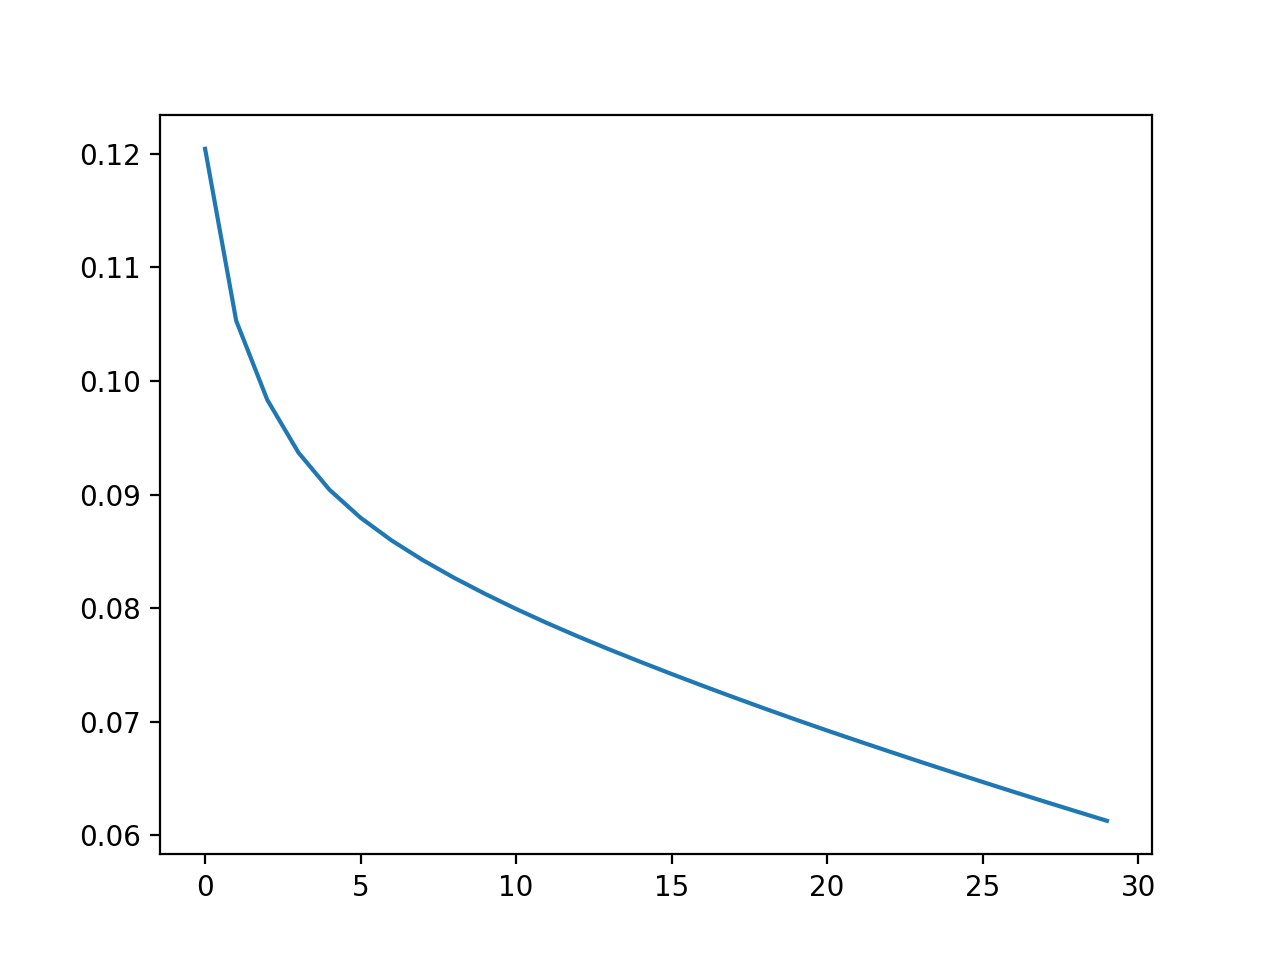

In [16]:
model = BaselineModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
loss = torch.nn.CrossEntropyLoss()

nepochs = 30
Esave = []

for e in range(nepochs):    
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

### 3.2 Batch Norm Model Training Loop

<IPython.core.display.Javascript object>


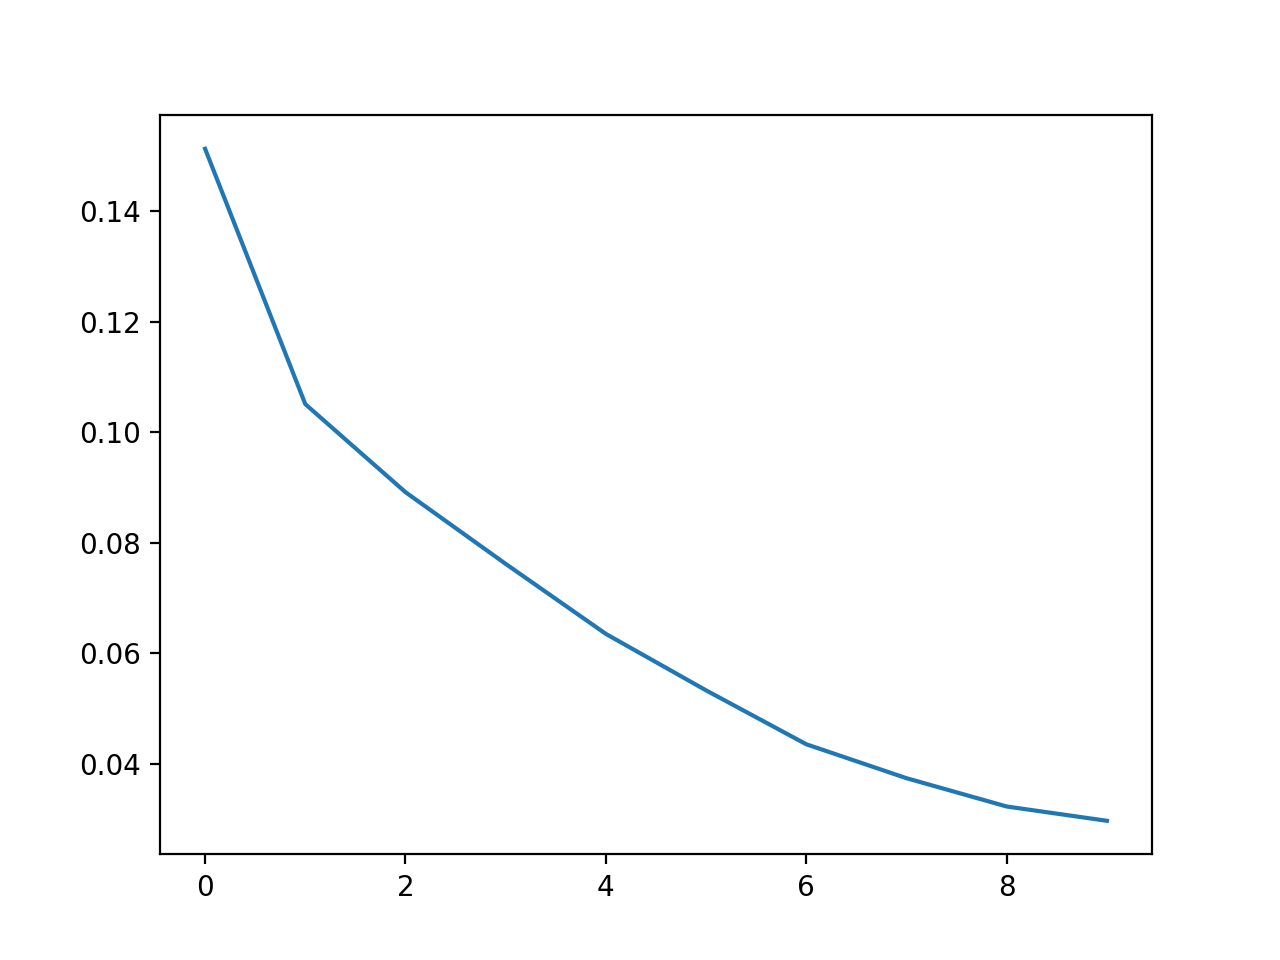

In [21]:
batch_model = BatchNormModel()
batch_model = batch_model.to(device)
optimizer = torch.optim.Adam(batch_model.parameters(),lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

nepochs = 10
Esave = []

for e in range(nepochs):    
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        # zero gradients
        optimizer.zero_grad()
        # forward
        out = batch_model(x)
        # loss
        E = loss(out,l.squeeze())
        # backward
        E.backward()
        # update
        optimizer.step()
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

### 3.3 Deeper Model Training Loop

<IPython.core.display.Javascript object>


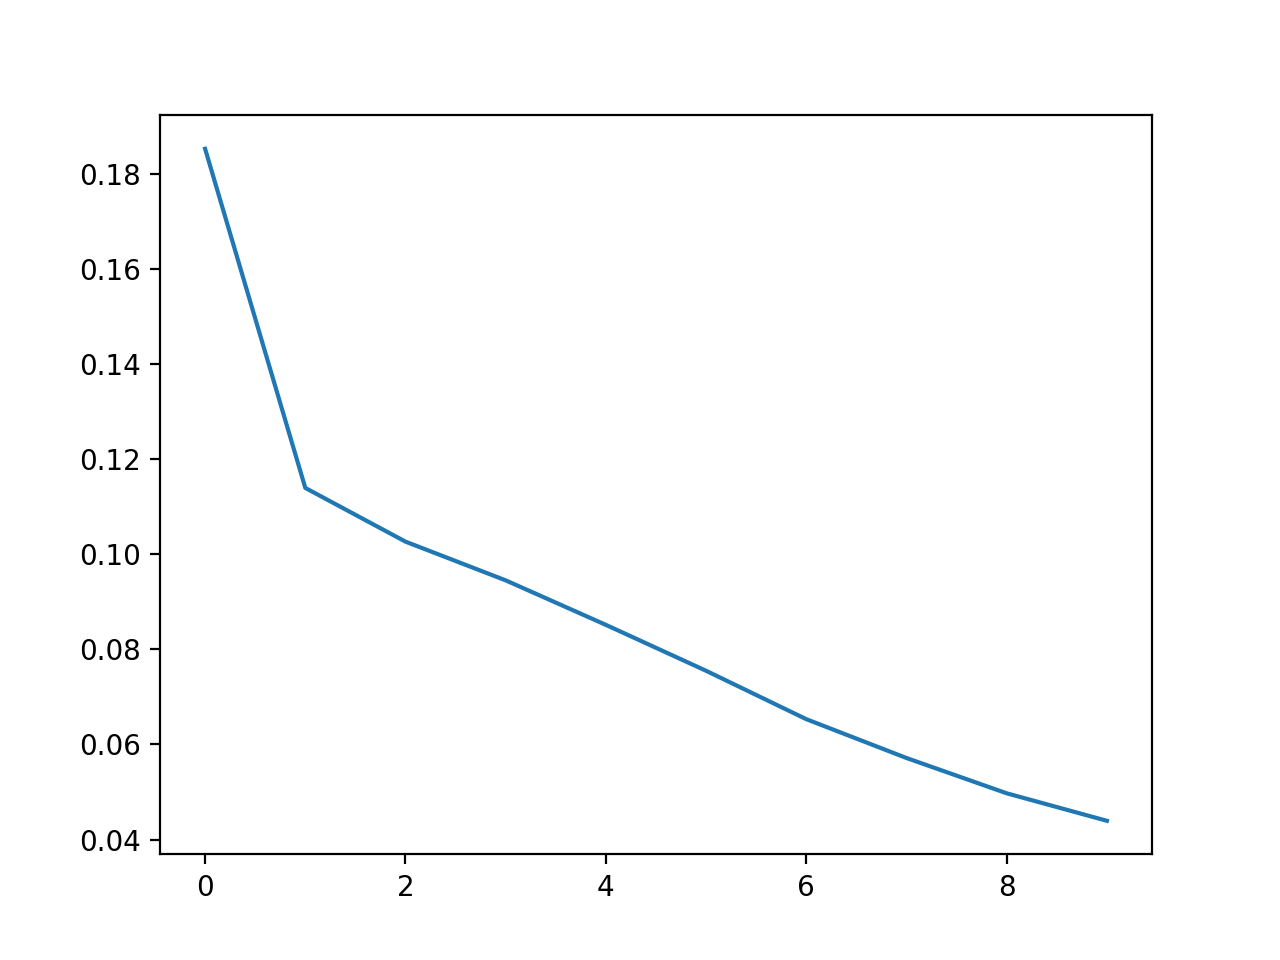

In [22]:
deep_model = DeeperModel()
deep_model = deep_model.to(device)
optimizer = torch.optim.Adam(deep_model.parameters(),lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

nepochs = 10
Esave = []

for e in range(nepochs):    
    Esum = 0.0
    for x,l in dataloader:
        x = x.to(device)
        l = l.to(device)
        # zero gradients
        optimizer.zero_grad()
        # forward
        out = deep_model(x)
        # loss
        E = loss(out,l.squeeze())
        # backward
        E.backward()
        # update
        optimizer.step()
        Esum += E.item()
    # draw
    Esave.append(Esum/len(dataset))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

## 4.0 Accuracy on train/val sets

In [17]:
def evaluate(model,
             dataloader_name):
    with torch.no_grad():
        count = 0
        correct = 0
        for x,l in dataloader_name:
            x = x.to(device)
            l = l.to(device)
            # forward
            out = model(x)
            c = torch.argmax(out,-1)
            count += x.shape[0]
            correct += torch.sum(c==l.squeeze()).item()
    return correct / count

In [18]:
acc = evaluate(model, dataloader)
print(acc)

0.818752675895533


In [19]:
acc = evaluate(model, dataloader_val)
print(acc)

0.7318045862412762


In [23]:
acc = evaluate(batch_model, dataloader)
print(acc)

0.8049093763379478


In [24]:
acc = evaluate(batch_model, dataloader_val)
print(acc)

0.6071784646061814


In [25]:
acc = evaluate(deep_model, dataloader)
print(acc)

0.8220351077493935


In [26]:
acc = evaluate(deep_model, dataloader_val)
print(acc)

0.654037886340977


## 5.0 Test Set Acccuracy

In [20]:
acc = evaluate(model, dataloader_test)
print(acc)

0.7346633416458853


## 6.0 Let's try data augmentation

- In this part we will try data augmentation:
    1. Do random horizontal flips
    2. Do random vertical flips
    3. Do a random rotation by 30 degress
    4. Add a color jitter


In [31]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

# Load DermaMNIST dataset with augmentation
train_dataset_augmented = DermaMNIST(split='train', download=True, transform=transform)
val_dataset_augmented = DermaMNIST(split='val', download=True, transform=torchvision.transforms.ToTensor())
test_dataset_augmented = DermaMNIST(split='test', download=True, transform=torchvision.transforms.ToTensor())

# Create a data loader
train_dataloader_augmented = torch.utils.data.DataLoader(train_dataset_augmented, batch_size=8, shuffle=True)
val_dataloader_augmented = torch.utils.data.DataLoader(val_dataset_augmented, batch_size=8, shuffle=True)
test_dataloader_augmented = torch.utils.data.DataLoader(test_dataset_augmented, batch_size=8, shuffle=True)

Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/blakedickerson/.medmnist/dermamnist.npz


/var/folders/vm/lrrp2hhj1lb4qz4b822s6mt80000gn/T/ipykernel_2651/2574709979.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


<IPython.core.display.Javascript object>


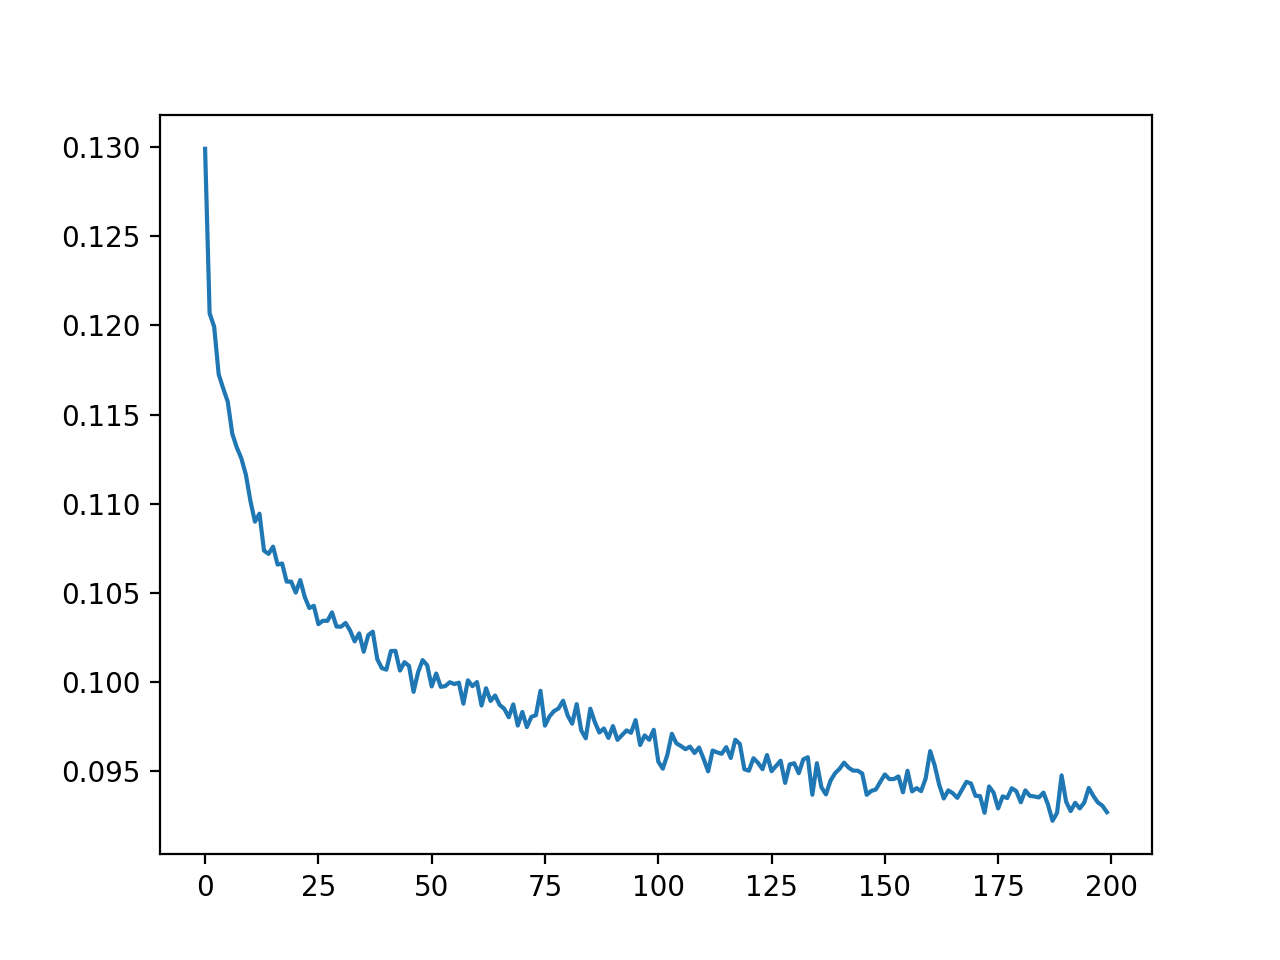

In [32]:
model = BaselineModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

nepochs = 200
Esave = []
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):    
    Esum = 0.0
    for x,l in train_dataloader_augmented:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(train_dataset_augmented))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

In [33]:
acc = evaluate(model,train_dataloader_augmented)
print(acc)

0.7282717282717283


In [34]:
acc = evaluate(model, val_dataloader_augmented)
print(acc)

0.4835493519441675


In [35]:
acc = evaluate(model, test_dataloader_augmented)
print(acc)

0.49226932668329176


<IPython.core.display.Javascript object>


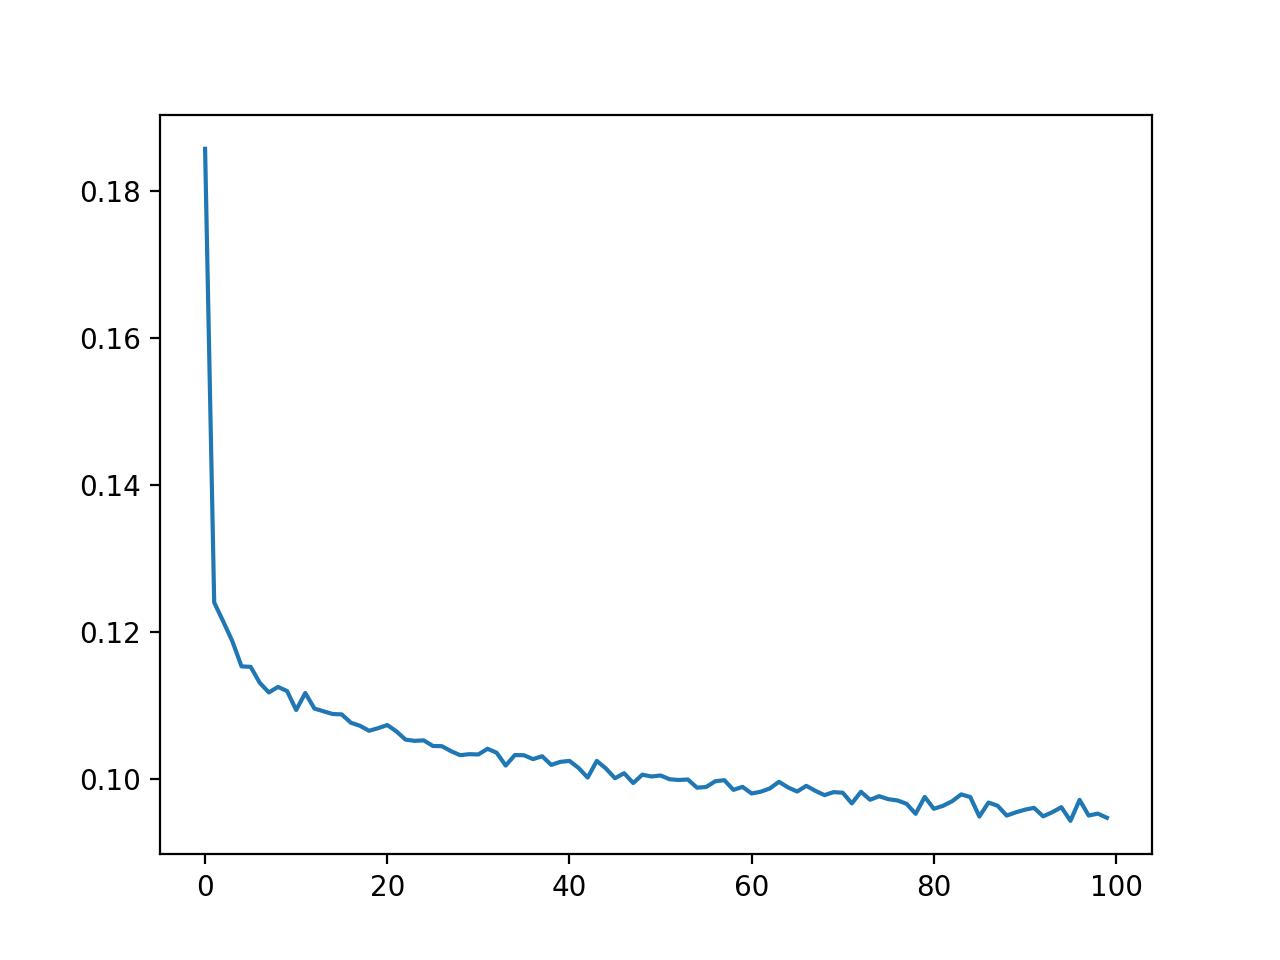

In [36]:
model = DeeperModel()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss = torch.nn.CrossEntropyLoss()

nepochs = 100
Esave = []
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()
for e in range(nepochs):    
    Esum = 0.0
    for x,l in train_dataloader_augmented:
        x = x.to(device)
        l = l.to(device)
        
        # zero gradients
        optimizer.zero_grad()
        
        
        # forward
        out = model(x)
        
        # loss
        E = loss(out,l.squeeze())
        
        # backward
        E.backward()
        
        # update
        optimizer.step()
        
        Esum += E.item()
    
    # draw
    Esave.append(Esum/len(train_dataset_augmented))
    if e == 0:
        fig,ax = plt.subplots()
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

In [37]:
acc = evaluate(model,train_dataloader_augmented)
print(acc)

0.7268445839874411


In [38]:
acc = evaluate(model, val_dataloader_augmented)
print(acc)

0.5134596211365903


In [39]:
acc = evaluate(model, test_dataloader_augmented)
print(acc)

0.5032418952618454


## Part 3, image segmentation

For this problem we will use the lung segmentation dataset already shared in class.

In [40]:
x = np.load('images_x.npy')
y = np.load('segmentations_y.npy')

In [41]:
class LungDataset(torch.utils.data.Dataset):
    def __init__(self,split='train'):
        if split not in ['train','test','val']:
            raise Exception(f'split must be train test or val, but you input {split}')
        self.split = split
        if split == 'train':
            self.x = x[:-20].reshape((-1,1,64,64,))
            self.y = y[:-20].reshape((-1,1,64,64,))
        elif split == 'test':
            self.x = x[-10:].reshape((-1,1,64,64,))
            self.y = y[-10:].reshape((-1,1,64,64,))
        elif split == 'val':
            self.x = x[-20:-10].reshape((-1,1,64,64,))
            self.y = y[-20:-10].reshape((-1,1,64,64,))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self,i):
        return torch.tensor(self.x[i],dtype=torch.float32),torch.tensor( np.concatenate((self.y[i],1.0-self.y[i]))  , dtype=torch.float32)

**Note: here I recall the RandomizedDataset class because we need a 64x64 torch tensor rather than a 28x28**

In [42]:
class RandomizedDataset(torch.utils.data.Dataset):
    ''' A class to apply randomizations to your dataset'''
    def __init__(self,dataset,
                 random_rotate=False,
                 random_reflect=False, 
                 random_affine=False,
                 random_deformation=False,
                 random_window_level=False,
                 random_gamma=False,
                 random_noise=False,
                ):
        # set the dataset to a member variable
        self.dataset = dataset
        
        
        
        # set the options to apply randomizations to member variables
        self.random_rotate = random_rotate
        self.random_reflect = random_reflect
        self.random_affine = random_affine
        self.random_deformation = random_deformation
        self.random_window_level = random_window_level
        self.random_gamma = random_gamma
        self.random_noise = random_noise
        
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,i):
        I,l = self.dataset[i]
        # check if the labels are segmentation labels
        # if they are, we will have to apply the same transformations
        # to the labels and the images
        if l.ndim == 1:
            l_is_image = False
        else:
            l_is_image = True
        
        # apply geometric transformations
        # note that we will need to apply the same transform to the image and segmentation
        if self.random_rotate:
            nrot = np.random.randint(4)
            I = torch.rot90(I,nrot,dims=(-1,-2))
            if l_is_image:
                l = torch.rot90(l,nrot,dims=(-1,-2))
        
        if self.random_reflect:
            if np.random.rand()>0.5:
                I = torch.flip(I,dims=(-1,-2))
                if l_is_image:
                    l = torch.flip(l,dims=(-1,-2))
        # get zero centered pixel locations
        x0 = torch.arange(I.shape[-2]) - (I.shape[-2]-1)/2
        x1 = torch.arange(I.shape[-1]) - (I.shape[-1]-1)/2
        X = torch.stack(torch.meshgrid(x0,x1,indexing='ij'),-1)        
        if self.random_affine:
            
            # a random matrix is added to identity for the linear part
            L = torch.eye(2) + torch.randn(2,2)*0.1
            # a random translation with standard deviation of 3 pixels is added to the tanslation
            T = torch.randn(2,1)*3
            # concatenate them
            A = torch.concatenate((L,T),-1)
            A = torch.concatenate((A,torch.tensor([[0.0,0.0,1.0]])),-2)
            Ai = torch.linalg.inv(A)
            # get sample points
            Xs = (Ai[:2,:2]@X[...,None])[...,0] + Ai[:2,-1]
            I = interpn([x0,x1],I,Xs,padding_mode='border')
            if l_is_image:                
                # note we use 'nearest neighbor' interpolation for labels
                l = interpn([x0,x1],l,Xs,mode='nearest',padding_mode='border')
        if self.random_deformation:
            # YOUR WORK HERE
            # 
            # 1. 
            # create 2 28x28 torch tensors which will represent the row and col components of your displacement fields
            # 
            # p0 = ...
            # p1 = ...  
#             p0 = torch.randn(28, 28)
#             p1 = torch.randn(28, 28)
            p0 = torch.randn(64, 64)
            p1 = torch.randn(64, 64)
            # 2. 
            # multiply them by whatever standard deviation you choose, this will relate to the magnitude of displacement
            # 
            std_deviation = 1.0
            p0 *= std_deviation
            p1 *= std_deviation
            # 3. 
            # blur it with a gaussian kernel of whatever width you choose
            # I suggest using the function:  torchvision.transforms.functional.gaussian_blur            
            # but there are other choices we have covered in class        
            # if you use this choice you will have to add a leading dimension to the input, and remove it from the output
            # example of adding and removing a leading dimension:
            # * blurred_image = blur( my_image[None])[0]
            # 
            kernel_size = 5
            sigma = 1.0 # Adjust sigma as needed

            # Apply Gaussian blur to p0 and p1
            p0 = torchvision.transforms.functional.gaussian_blur(p0[None], kernel_size, sigma)[0]
            p1 = torchvision.transforms.functional.gaussian_blur(p1[None], kernel_size, sigma)[0]
            # 4. 
            # stack p0 and p1 into a 28x28x2 array and            
            # interpolate your images at X - your_random_displacement_field
            # Xs = X - torch.stack((p0,p1))
            # ...
            # see the above affine transform for any help with interpolation
            # 
            # make sure the std and kernel size you choose lead to realistic images
            displacement_field = torch.stack((p0, p1), dim=-1)
            Xs = X - displacement_field
            I = interpn([x0, x1], I, Xs, padding_mode='border')
            if l_is_image:
                l = interpn([x0, x1], l, Xs, mode='nearest', padding_mode='border')
            pass
                
            
            
            
        
        # apply pixel intsenity transforations
        # these will be applied only to the image
        # and not to the labels
        if self.random_window_level:
            # YOUR WORK HERE!
            # choose a vmin randomly between 0 and 0.25
            # choose a vmax randomly between 0.75 and 1
            # rescale the image so that vmin maps to 0, and vmax maps to 1
            # clip any pixels less than 0 to the value 0
            # clip any pixels greater than 1 to the value 1
            vmin = torch.FloatTensor(1).uniform_(0, 0.25).item()
            vmax = torch.FloatTensor(1).uniform_(0.75, 1).item()
            I = (I - vmin) / (vmax - vmin)
            I = torch.clamp(I, min=0)
            I = torch.clamp(I, max=1)
            pass
            
        if self.random_gamma:            
            gamma_ = (np.random.rand()*2-1) # between -1 and 1
            gamma = 2.0**gamma_ # between 0.5 and 2.0
            I = I**gamma
            
        if self.random_noise:
            frac = 0.05
            I = I*(1-frac) + torch.rand(*I.shape)*frac
        return I,l
        
        
    

In [43]:
dataset_lung_train = LungDataset(split='train')
I,l = dataset_lung_train[0]

In [44]:
dataset_lung_train_randomized = RandomizedDataset(
    dataset_lung_train,
    random_deformation=True,
    random_affine=True,
    random_gamma=True,
    random_window_level=True,
    random_noise=True,
)

<IPython.core.display.Javascript object>


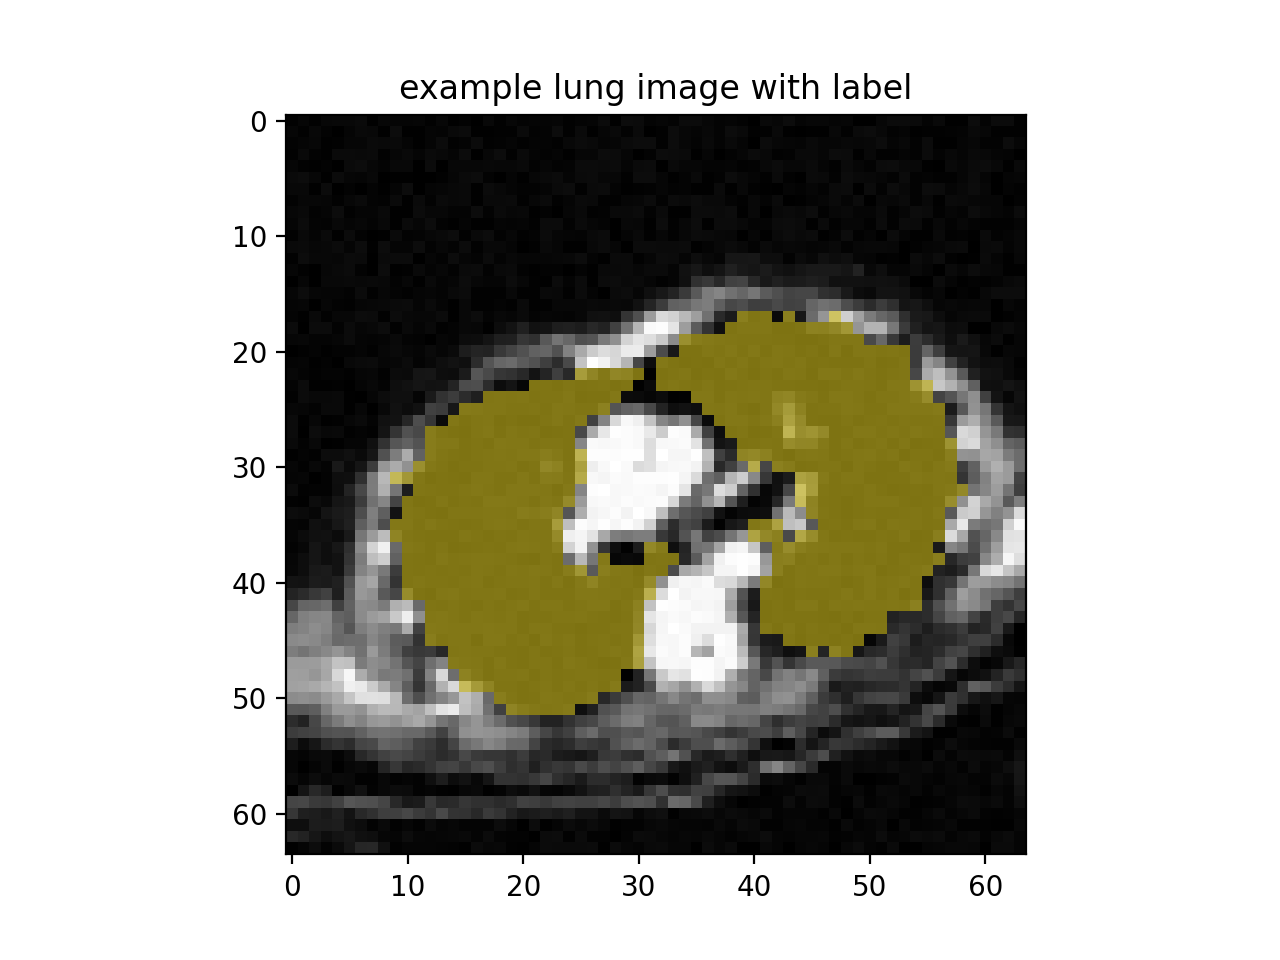

<IPython.core.display.Javascript object>


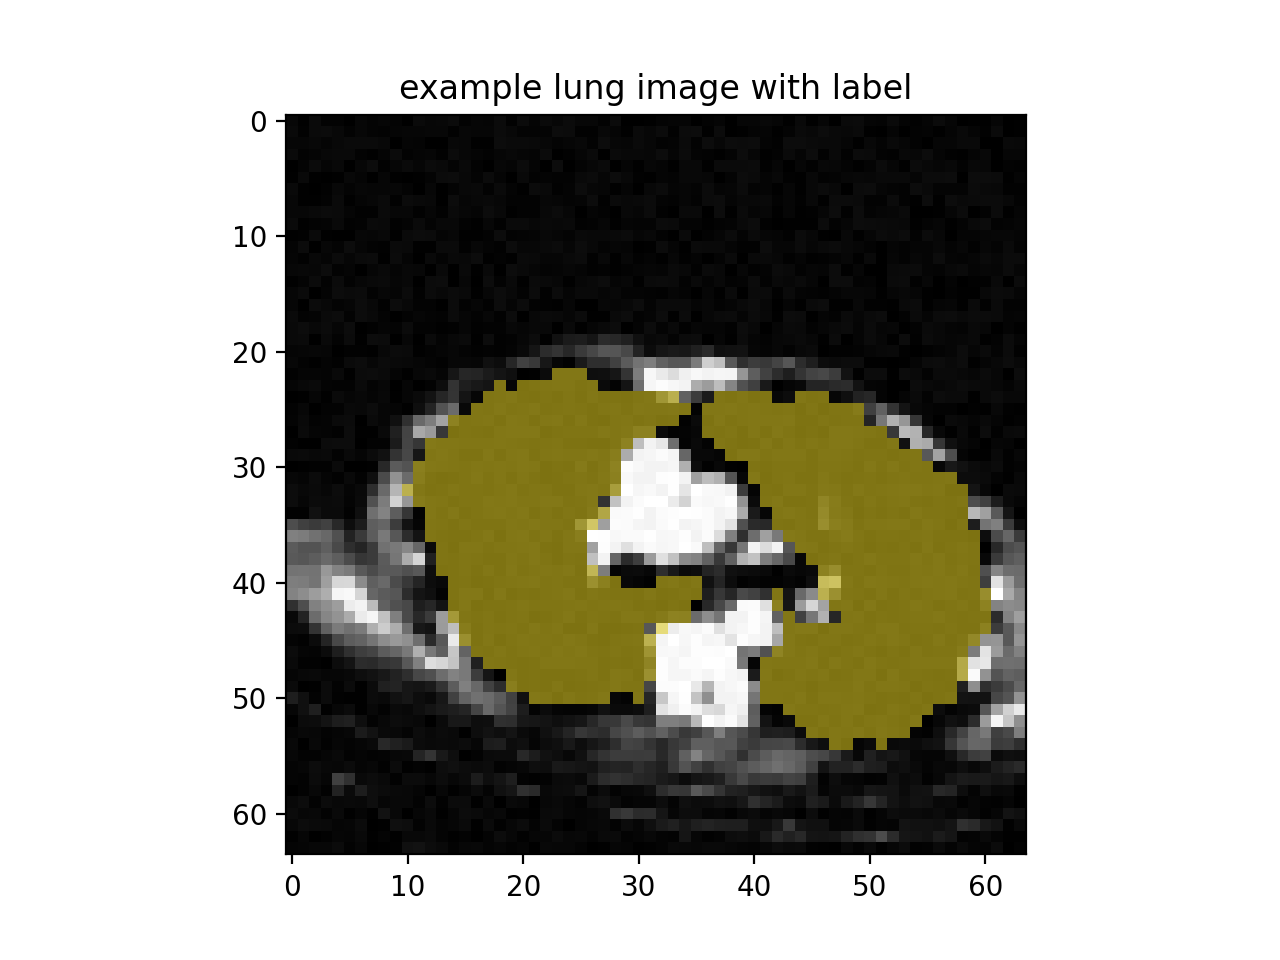

<IPython.core.display.Javascript object>


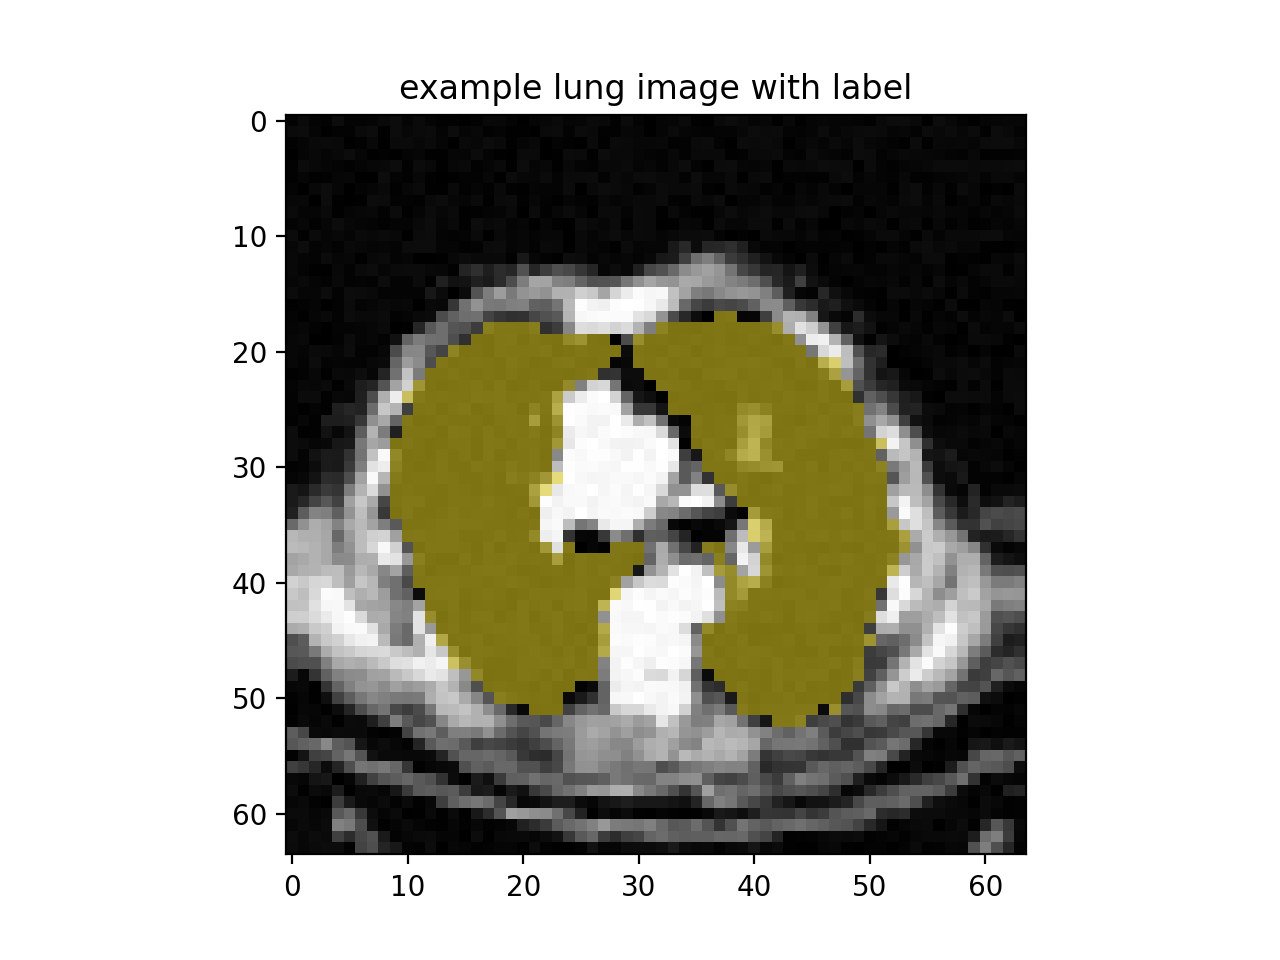

<IPython.core.display.Javascript object>


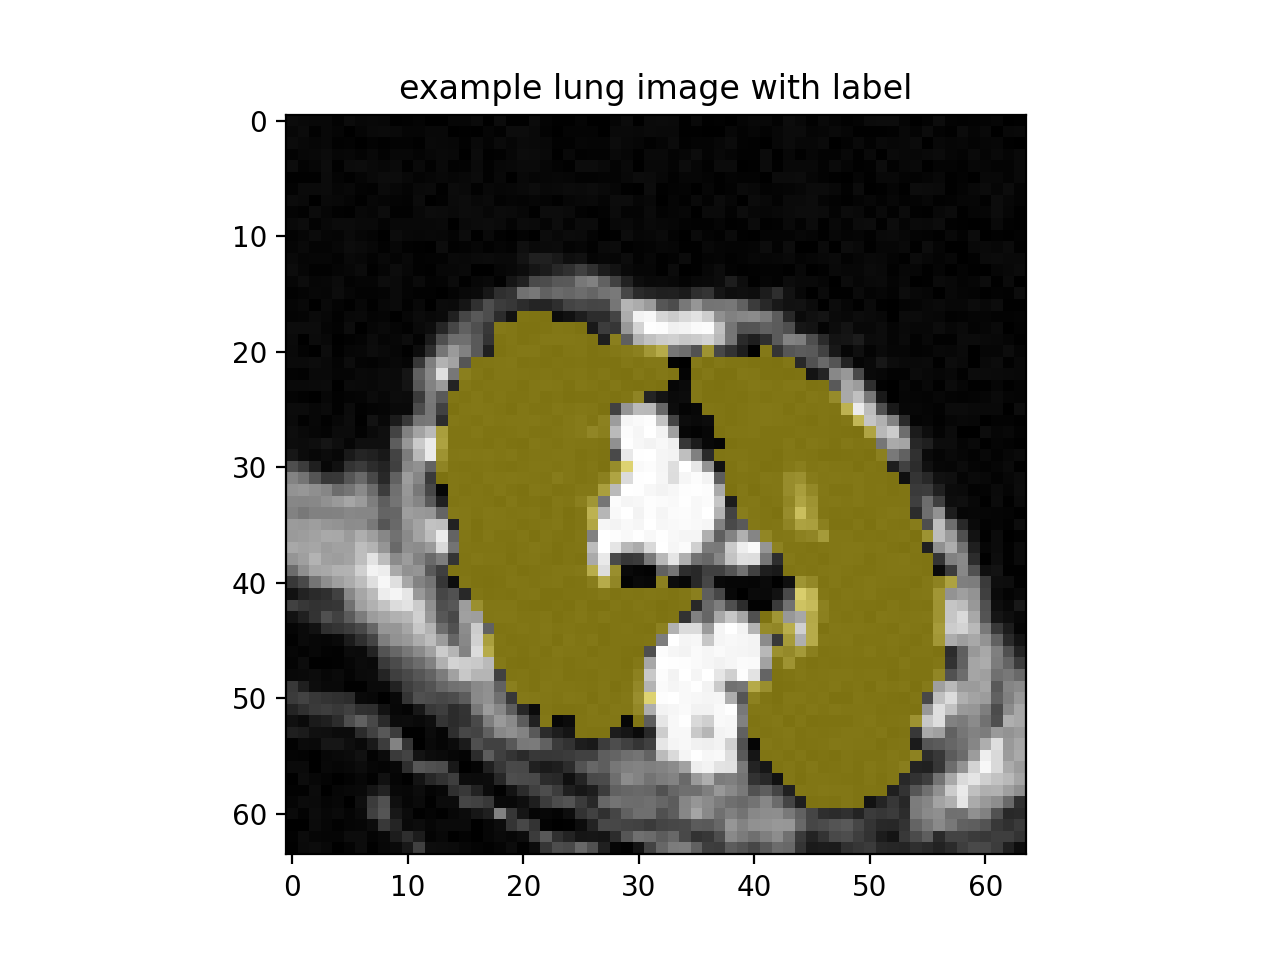

<IPython.core.display.Javascript object>


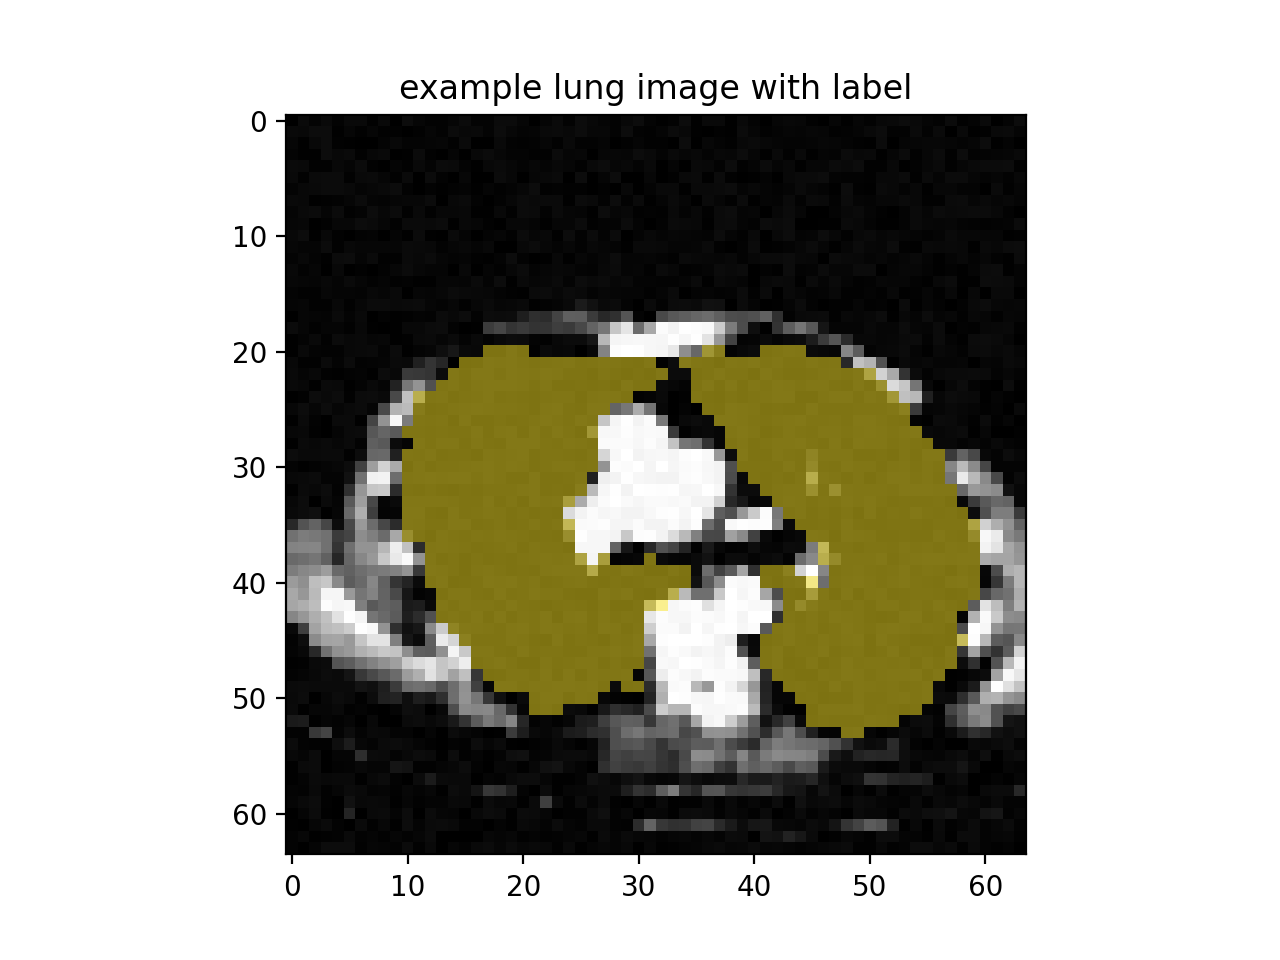

In [45]:
for i in range(5):
    I,l = dataset_lung_train_randomized[0]
    fig,ax = plt.subplots()
    ax.imshow(I[0],cmap='gray')
    ax.imshow(l[0],alpha=l[0]*0.5)
    ax.set_title('example lung image with label')

### Problem 3.1
Design at least two CNNs for segmenting the lung segmentation dataset.

You can choose any design you want, but at least one of the models should not be a copy of what we showed in class.

You may choose to vary the depth or width of the network, the type of data augmentation, any regularization, the loss function, the optimizer, etc.

You may (or may not) wish to make a new version of your randomization class, where you chose different parameters to generate realistic datasets.

In this dataset, flips and 90 degree rotations may (or may not) be useful, since all the images are already in a standard pose. You can investigate this in one of your training strategies if you want.

Train them on the training set (for however long you want), and test their Dice score and Hausdorff distance on the validation set.

Choose the best performing model on the validation set (using whatever criteria you'd like), and report its Haussdorf distance and Dice score on the test set.

I will rerun your notebook, and evaluate perforance in terms of Dice and Hausdorff on a random subset of the test set.  The random subset will be the same for all students.  2.5% of your grade (out of 100%) on this assignment will be based on your Dice score relative to the other students.  The student with the highest Dice will recieve 2.5%. The student with the lowest Dice will recieve 0%.  The others will vary linearly between these extremes.  

Another 2.5% of your grade (out of 100%) on this assignment will be based on your Hausdorff distance relative to the other students.  The student with the lowest distance will recieve 2.5%. The student with the highest distance will recieve 0%.  The others will vary linearly between these extremes.  

### 1.0 Get our Training Data

In [46]:
dataloader = torch.utils.data.DataLoader(dataset_lung_train_randomized,
                                         batch_size=8)

### 2.0 Build Baseline Model

In [47]:
class SegmentationNet(torch.nn.Module):
    def __init__(self):
        super(SegmentationNet, self).__init__()
        
        #Encoder
        self.e0 = torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        # decoder
        self.d0 = torch.nn.ConvTranspose2d(in_channels=8, out_channels=2, kernel_size=3)
    
    def forward(self, x):
        x = torch.relu(self.e0(x))
        x = torch.relu(self.d0(x))
        return x

In [52]:
class ImprovedSegmentationNet(torch.nn.Module):
    def __init__(self):
        super(ImprovedSegmentationNet, self).__init__()
        
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # Pooling layer
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.MaxPool2d(2)
        )
        
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=2, stride=2),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=8, out_channels=2, kernel_size=2, stride=2),
            torch.nn.BatchNorm2d(2),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


For this model I have decided to try to implement the deep lab architecture from the following link:
- https://paperswithcode.com/method/deeplabv3#:~:text=DeepLabv3%20is%20a%20semantic%20segmentation,by%20adopting%20multiple%20atrous%20rates.
- https://medium.com/@itberrios6/deeplabv3-c0c8c93d25a4

In [58]:
class DeepLab(torch.nn.Module):
    def __init__(self):
        super(DeepLab, self).__init__()
        
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True)
        )
        self.aspp = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, dilation=3, padding=3),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, dilation=6, padding=6),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, dilation=12, padding=12),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),
            torch.nn.ReLU(inplace=True)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2), # Upsample to 32x32
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2), # Upsample to 64x64
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=2, kernel_size=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.aspp(x)
        x = self.decoder(x)
        return x


## 3.0 Build Training Loops

### 3.1 Baseline Model Training Loop

<IPython.core.display.Javascript object>


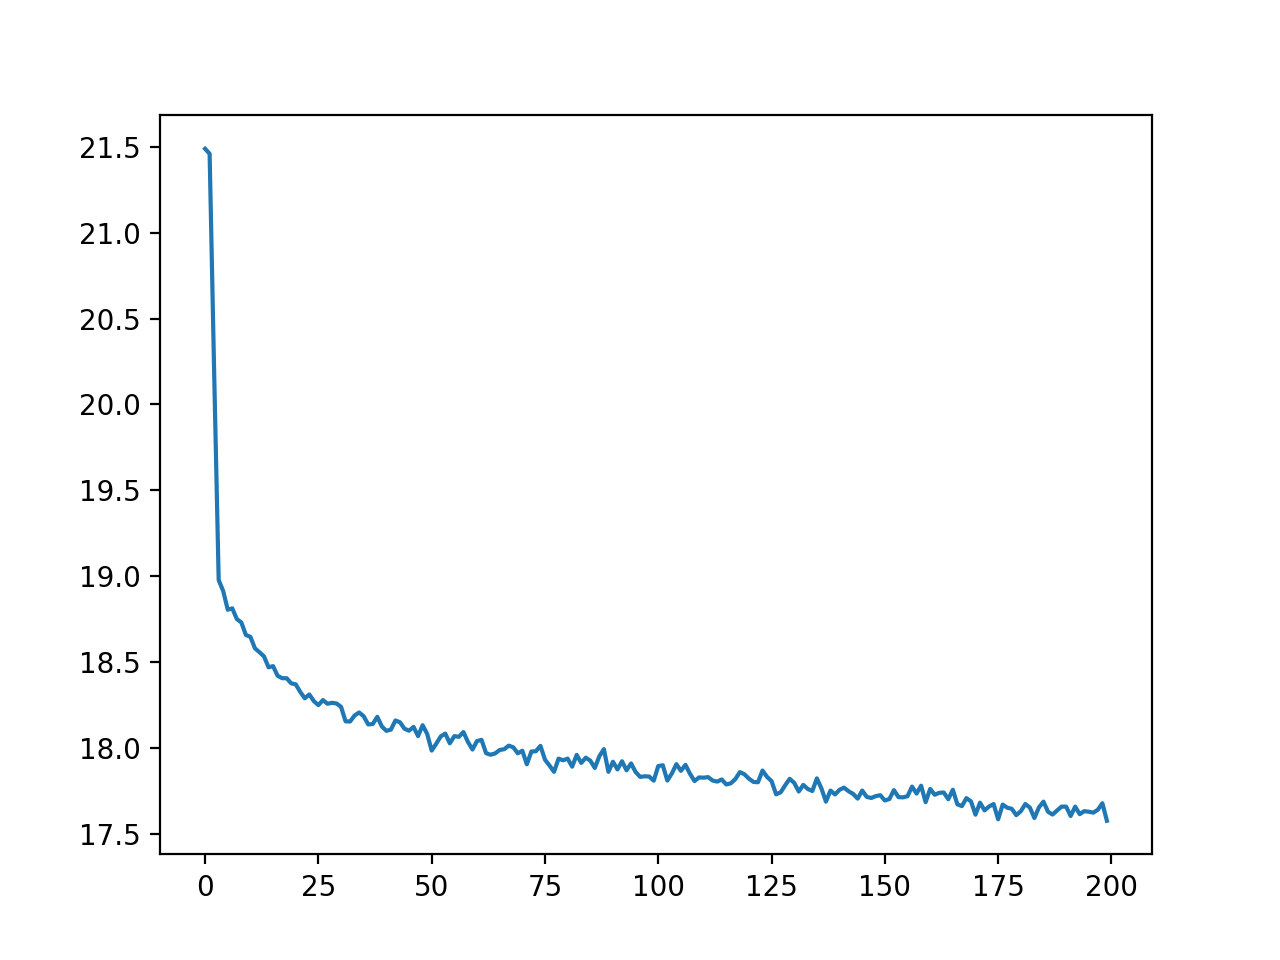

In [50]:
baseline_model = SegmentationNet().to(device) # instantiate model and send it to gpu
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

nepochs = 200
fig, ax = plt.subplots()
Esave = []

for e in range(nepochs):
    Esum = 0.0
    for x, l in dataloader:
        optimizer.zero_grad()

        # Ensure x and l are on the correct device
        x, l = x.to(device), l.to(device)

        # Forward pass
        lhat = baseline_model(x)
        
        # Loss calculation
        E = loss(lhat, l)
        
        E.backward()
        optimizer.step()
        
        Esum += E.item()
    
    Esave.append(Esum)
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

### 3.2 Improved Model Training Loop

<IPython.core.display.Javascript object>


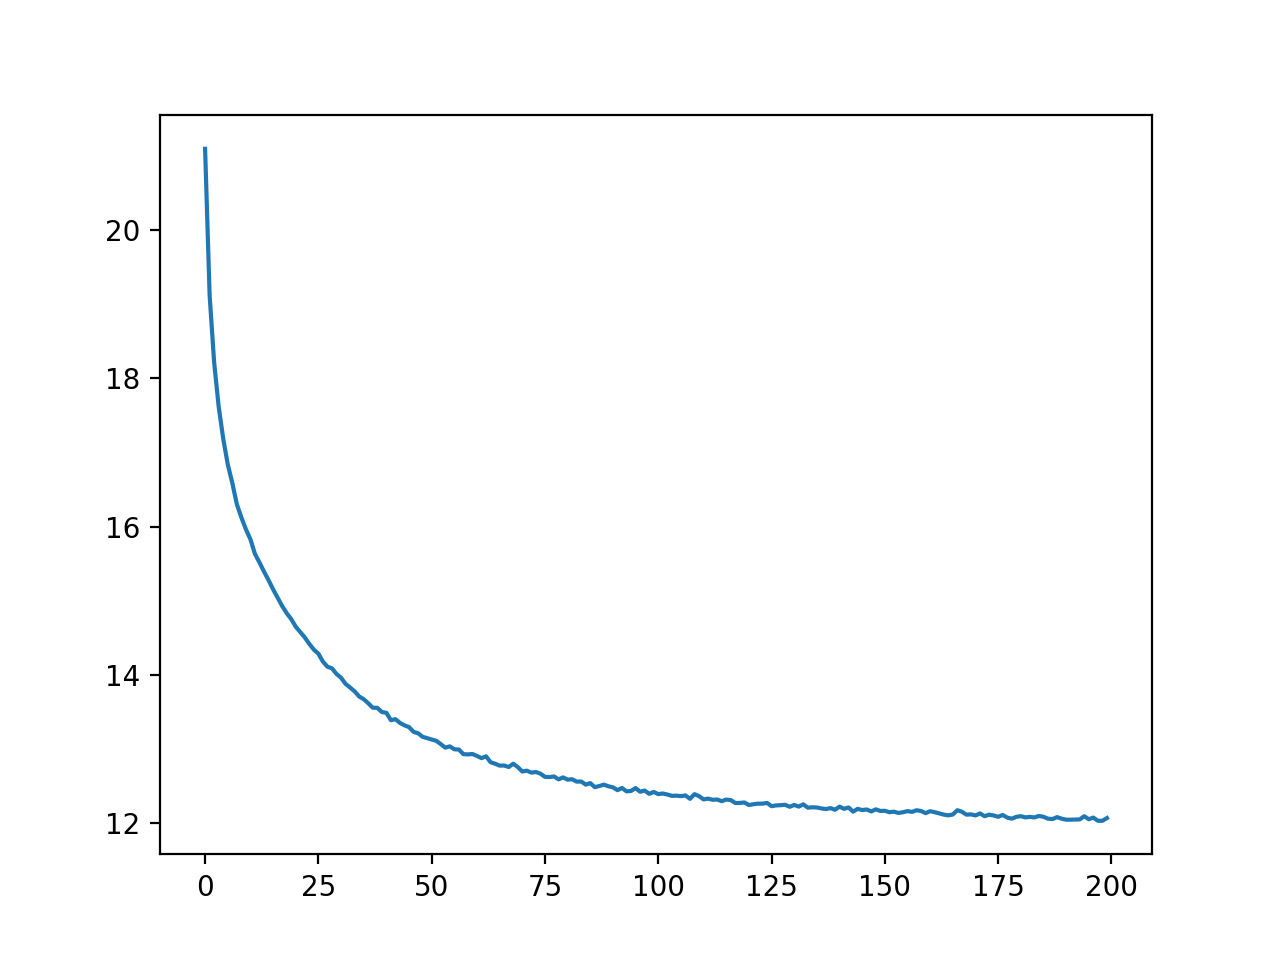

In [54]:
model2 = ImprovedSegmentationNet().to(device) # instantiate model and send it to gpu
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

nepochs = 200
fig, ax = plt.subplots()
Esave = []

for e in range(nepochs):
    Esum = 0.0
    for x, l in dataloader:
        optimizer.zero_grad()

        # Ensure x and l are on the correct device
        x, l = x.to(device), l.to(device)

        # Forward pass
        lhat = model2(x)
        
        # Loss calculation
        E = loss(lhat, l)
        
        E.backward()
        optimizer.step()
        
        Esum += E.item()
    
    Esave.append(Esum)
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

### 3.3 Deep Lab Training Loop

<IPython.core.display.Javascript object>


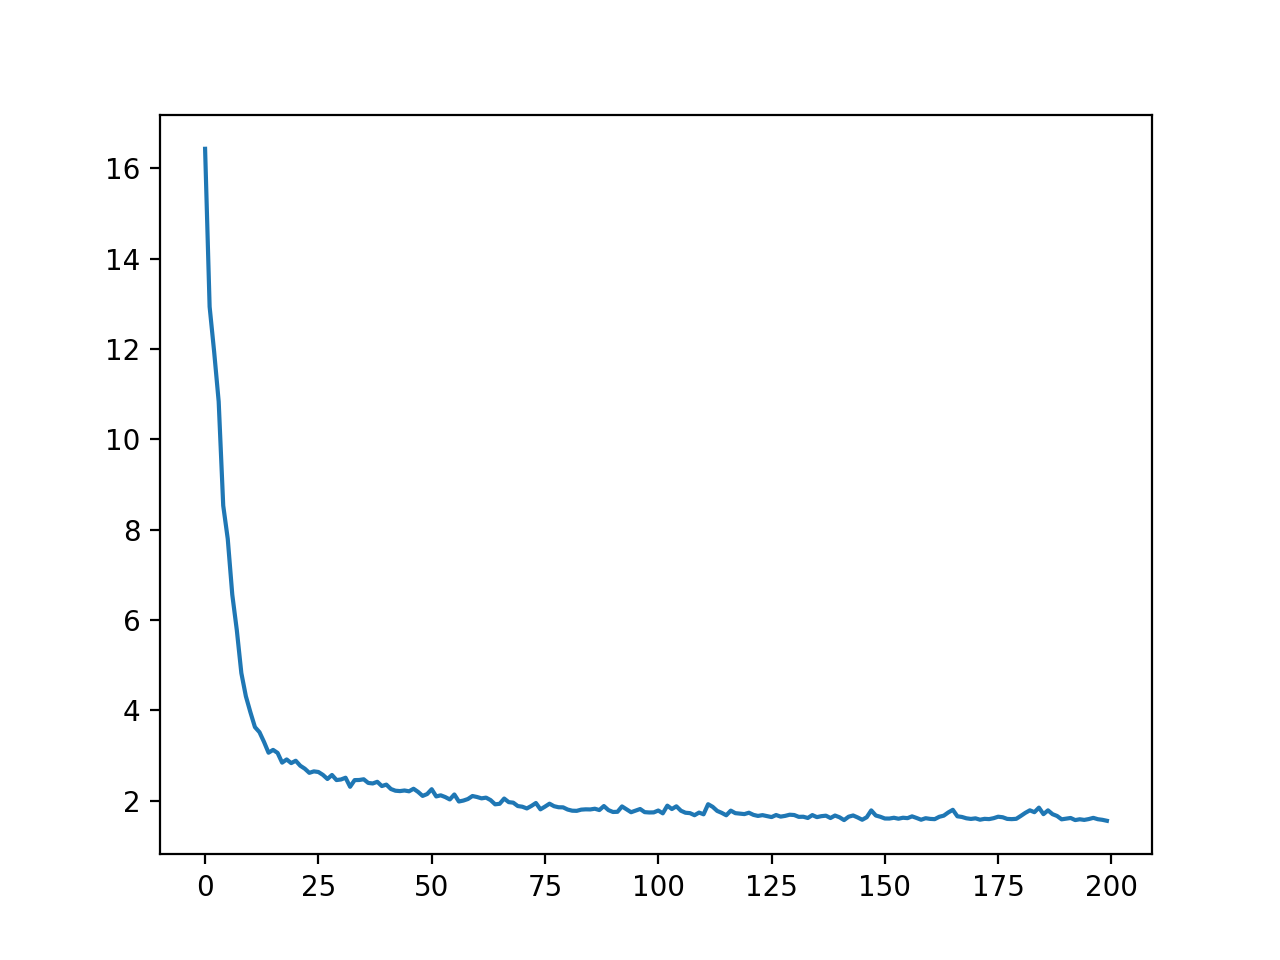

In [59]:
model3 = DeepLab().to(device) # instantiate model and send it to gpu
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

nepochs = 200
fig, ax = plt.subplots()
Esave = []

for e in range(nepochs):
    Esum = 0.0
    for x, l in dataloader:
        optimizer.zero_grad()

        # Ensure x and l are on the correct device
        x, l = x.to(device), l.to(device)

        # Forward pass
        lhat = model3(x)
        
        # Loss calculation
        E = loss(lhat, l)
        
        E.backward()
        optimizer.step()
        
        Esum += E.item()
    
    Esave.append(Esum)
    ax.cla()
    ax.plot(Esave)
    fig.canvas.draw()

## Check Performance on Validation Set

### Get Validation Data

In [60]:
dataset_lung_test = LungDataset(split='test')
dataset_lung_val = LungDataset(split='val')

**Note: for some reason my validation dataset has 0 samples in it so I will just use the test dataset for the scoring**

In [61]:
len(dataset_lung_test), len(dataset_lung_val)

(7, 0)

In [62]:
dataset_lung_val_randomized = RandomizedDataset(
    dataset_lung_val,
    random_deformation=True,
    random_affine=True,
    random_gamma=True,
    random_window_level=True,
    random_noise=True,
)
len(dataset_lung_val_randomized)

0

In [63]:
dataloader_test = torch.utils.data.DataLoader(dataset_lung_test,
                                              batch_size=8)

### Compute Scores/Distances

- In this section we compute our hausdorff distance and dice score:
    1. I used the hausdorff function from the scipy library https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.directed_hausdorff.html
    2. I got a function that computes the dice score from this link: https://www.grepper.com/answers/40836/code+to+calculate+dice+score

In [64]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(predictions, true_labels):
    predictions = (predictions > 0.5).astype(np.uint8)
    true_labels = (true_labels > 0.5).astype(np.uint8)
    predictions = predictions[:, 0, :, :]
    true_labels = true_labels[:, 0, :, :]
    hd_values = []
    for pred, true_label in zip(predictions, true_labels):
        hd = max(directed_hausdorff(pred, true_label)[0],
                 directed_hausdorff(true_label, pred)[0])
        hd_values.append(hd)
    return np.mean(hd_values)


In [65]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

In [66]:
# Set the model to evaluation mode
baseline_model.eval()

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for x, l in dataloader_test:
        # Move data to the correct device
        x, l = x.to(device), l.to(device)
        
        # Get predictions
        lhat = baseline_model(x)
        
        # Convert predictions to binary masks (assuming your model outputs probabilities)
        binary_predictions = (lhat > 0.5).float().cpu().numpy()
        
        # Convert true labels to binary masks
        binary_true_labels = (l > 0.5).float().cpu().numpy()
        
        # Append predictions and true labels
        predictions.append(binary_predictions)
        true_labels.append(binary_true_labels)

# Concatenate all predictions and true labels into single arrays
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

# Calculate Hausdorff distance and Dice score
hausdorff_distance_value = hausdorff_distance(predictions, true_labels)
dice_score_value = dice_coef2(predictions, true_labels)

print(f"Hausdorff Distance: {hausdorff_distance_value}")
print(f"Dice Score: {dice_score_value}")


Hausdorff Distance: 6.292661064201671
Dice Score: 0.7486443616511121


/var/folders/vm/lrrp2hhj1lb4qz4b822s6mt80000gn/T/ipykernel_2651/3432696787.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i],dtype=torch.float32),torch.tensor( np.concatenate((self.y[i],1.0-self.y[i]))  , dtype=torch.float32)


In [67]:
# Set the model to evaluation mode
model2.eval()

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for x, l in dataloader_test:
        # Move data to the correct device
        x, l = x.to(device), l.to(device)
        
        # Get predictions
        lhat = model2(x)
        
        # Convert predictions to binary masks (assuming your model outputs probabilities)
        binary_predictions = (lhat > 0.5).float().cpu().numpy()
        
        # Convert true labels to binary masks
        binary_true_labels = (l > 0.5).float().cpu().numpy()
        
        # Append predictions and true labels
        predictions.append(binary_predictions)
        true_labels.append(binary_true_labels)

# Concatenate all predictions and true labels into single arrays
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

# Calculate Hausdorff distance and Dice score
hausdorff_distance_value = hausdorff_distance(predictions, true_labels)
dice_score_value = dice_coef2(predictions, true_labels)

print(f"Hausdorff Distance: {hausdorff_distance_value}")
print(f"Dice Score: {dice_score_value}")


Hausdorff Distance: 4.417623154711715
Dice Score: 0.8136793287782773


/var/folders/vm/lrrp2hhj1lb4qz4b822s6mt80000gn/T/ipykernel_2651/3432696787.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i],dtype=torch.float32),torch.tensor( np.concatenate((self.y[i],1.0-self.y[i]))  , dtype=torch.float32)


In [68]:
model3.eval()

# Initialize lists to store predictions and true labels
predictions = []
true_labels = []

# Evaluate the model on the test set
with torch.no_grad():
    for x, l in dataloader_test:
        # Move data to the correct device
        x, l = x.to(device), l.to(device)
        
        # Get predictions
        lhat = model3(x)
        
        # Convert predictions to binary masks (assuming your model outputs probabilities)
        binary_predictions = (lhat > 0.5).float().cpu().numpy()
        
        # Convert true labels to binary masks
        binary_true_labels = (l > 0.5).float().cpu().numpy()
        
        # Append predictions and true labels
        predictions.append(binary_predictions)
        true_labels.append(binary_true_labels)

# Concatenate all predictions and true labels into single arrays
predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)

# Calculate Hausdorff distance and Dice score
hausdorff_distance_value = hausdorff_distance(predictions, true_labels)
dice_score_value = dice_coef2(predictions, true_labels)

print(f"Hausdorff Distance: {hausdorff_distance_value}")
print(f"Dice Score: {dice_score_value}")


Hausdorff Distance: 4.443799890827949
Dice Score: 0.8195960554764542


/var/folders/vm/lrrp2hhj1lb4qz4b822s6mt80000gn/T/ipykernel_2651/3432696787.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.x[i],dtype=torch.float32),torch.tensor( np.concatenate((self.y[i],1.0-self.y[i]))  , dtype=torch.float32)



## Part 4, the MEDMNIST paper

Read the paper, MedMNIST v2 - A large-scale lightweight benchmark for 2D and 3D biomedical image classification, shared on the course website.

### Problem 4.1

Why was this family of datasets developed?

This family of datasets was developed to be diverse, standardized, lightweight, and educational. The datasets solves the problem of complexity in the biomedical field. We can think of this family of datasets as a "jack of all trades". More specifically, it simplifies the background knowledge needed by the researcher, it has a wide range of scales and tasks, and includes both 2d and 3d images. Furthermore, a lot of the data cleaning is taken care of for us as all we have to do is get the correct split for the dataset. 

### Problem 4.2

For the DermaMNIST dataset, describe the medical problem that machine learning techniques could be used to solve or automate.

The DermaMNIST dataset develops a way for researchers to come up with machine learning techniques to solve or automate the detection of skin lesions. We use this dataset as a multi-class classificaiton problem as it has seven different classes for us to try and classify correctly. 

## Part 5, The Unet-Paper

Read the paper, U-Net: Convolutional Networks for Biomedical Image Segmentation, shared on the course website.

### Problem 5.1

What task was the unet developed to solve?

The unet was tasked to solve the issue of limited annotated samples. The authors state that they use data augmentation to "use the available annotated samples more efficiently" (U-Net: Convolutional Networks for Biomedical Image Segmentation). More specifically, the authors use data augmentation to allow a model to be trained from a few images. This is crucial because the medical field has so few images to begin with. Furthermore, this allows researchers to get more out of the data that is readily available to make breakthroughs until more data becomes available.

### Problem 5.2
Describe 2 ways in which the model architecture presented in this paper differed from the basic unet model we discussed in class (note you can find more than two differences).

The first difference of architecture between the paper and the model in class is the use of a pooling layer. In the paper they use a pooling layer after the convolution layers in the downsampling section, while our model in class does not make use of any pooling layers. Another difference between the two is the size of the input channels. In the paper they use way more convolution layers than we did in class. For example, the paper states that they use a total of 23 convolutional layers. In comparison, we use a total of four convolutional layers for the downsample and a total of four convolutional layers for the upsample. 

### Problem 5.3
Describe how the cross entropy loss function presented in the paper different from the one defined in class?

In the paper it seems like they use a combination of the cross entropy loss function and a pixel-wise softmax over the final feature map. In class, we the the cross entropy loss function to perform an "image classification at each pixel". More specifically, the soft max takes a maximum activation in a feature channel at a pixel position and assigns a value to it. After this is done, it runs through the cross entropy loss which penalizes each softmax that is not a value of 1.

## Notes

- I would have liked to run a hyperparameter tune on my neural networks if I had more time
    - This would have consisted of:
        1. Adjusting the learning rate
        2. Adjusting the optimizer
        3. Adjusting the number of channels in the network
- I would have also liked to run a callback on the training loop to help avoid overfitting
    - For example, if our loss does not decrease over 5 or more epochs we would stop training